# ML Greop Project: Online News Popularity

## 1. Objective
- Evaluate factors contributing to the popularity of online news articles.
- Analyze 39,797 articles to classify and group them based on features (topics, word count, sentiment, etc.).
- Use supervised and unsupervised learning to examine relationships between article features and popularity.
- Conduct further analyses to optimize the model, including evaluating its sensitivity to training set size, tuning regularization strength, assessing feature importance, and refining outlier detection methods.


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
from scipy.cluster import hierarchy
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.svm import LinearSVC
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN, KMeans
import seaborn as sns

## Methods

### 2.1 Understanding the dataset 

**Original dataset**

In [27]:
df_news_pop = pd.read_csv('/Users/ethanlu/Desktop/Machine Learning/Final/ML Group Project Datasets/Online News Popularity/OnlineNewsPopularity/OnlineNewsPopularity.csv', sep=',')

news_pop = df_news_pop.drop(['url'], axis=1)
news_pop.head()

timedelta   n_tokens_title   n_tokens_content   n_unique_tokens  \
0       731.0             12.0              219.0          0.663594   
1       731.0              9.0              255.0          0.604743   
2       731.0              9.0              211.0          0.575130   
3       731.0              9.0              531.0          0.503788   
4       731.0             13.0             1072.0          0.415646   

    n_non_stop_words   n_non_stop_unique_tokens   num_hrefs   num_self_hrefs  \
0                1.0                   0.815385         4.0              2.0   
1                1.0                   0.791946         3.0              1.0   
2                1.0                   0.663866         3.0              1.0   
3                1.0                   0.665635         9.0              0.0   
4                1.0                   0.540890        19.0             19.0   

    num_imgs   num_videos  ...   min_positive_polarity  \
0        1.0          0.0  ...                0.100000   
1        1.0          0.0  ...                0.033333   
2        1.0          0.0  ...                0.100000   
3        1.0          0.0  ...                0.136364   
4       20.0          0.0  ...                0.033333   

    max_positive_polarity   avg_negative_polarity   min_negative_polarity  \
0                     0.7               -0.350000                  -0.600   
1                     0.7               -0.118750                  -0.125   
2                     1.0               -0.466667                  -0.800   
3                     0.8               -0.369697                  -0.600   
4                     1.0               -0.220192                  -0.500   

    max_negative_polarity   title_subjectivity   title_sentiment_polarity  \
0               -0.200000             0.500000                  -0.187500   
1               -0.100000             0.000000                   0.000000   
2               -0.133333             0.000000                   0.000000   
3               -0.166667             0.000000                   0.000000   
4               -0.050000             0.454545                   0.136364   

    abs_title_subjectivity   abs_title_sentiment_polarity   shares  
0                 0.000000                       0.187500      593  
1                 0.500000                       0.000000      711  
2                 0.500000                       0.000000     1500  
3                 0.500000                       0.000000     1200  
4                 0.045455                       0.136364      505  

[5 rows x 60 columns]

**Descriptive Statistics**

In [28]:
print(news_pop.info())
print(news_pop.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39644 entries, 0 to 39643
Data columns (total 60 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0    timedelta                      39644 non-null  float64
 1    n_tokens_title                 39644 non-null  float64
 2    n_tokens_content               39644 non-null  float64
 3    n_unique_tokens                39644 non-null  float64
 4    n_non_stop_words               39644 non-null  float64
 5    n_non_stop_unique_tokens       39644 non-null  float64
 6    num_hrefs                      39644 non-null  float64
 7    num_self_hrefs                 39644 non-null  float64
 8    num_imgs                       39644 non-null  float64
 9    num_videos                     39644 non-null  float64
 10   average_token_length           39644 non-null  float64
 11   num_keywords                   39644 non-null  float64
 12   data_channel_is_lifestyle      

**Duplicated values**

In [29]:
print(news_pop.duplicated().sum())

0


**Feature Distributions**

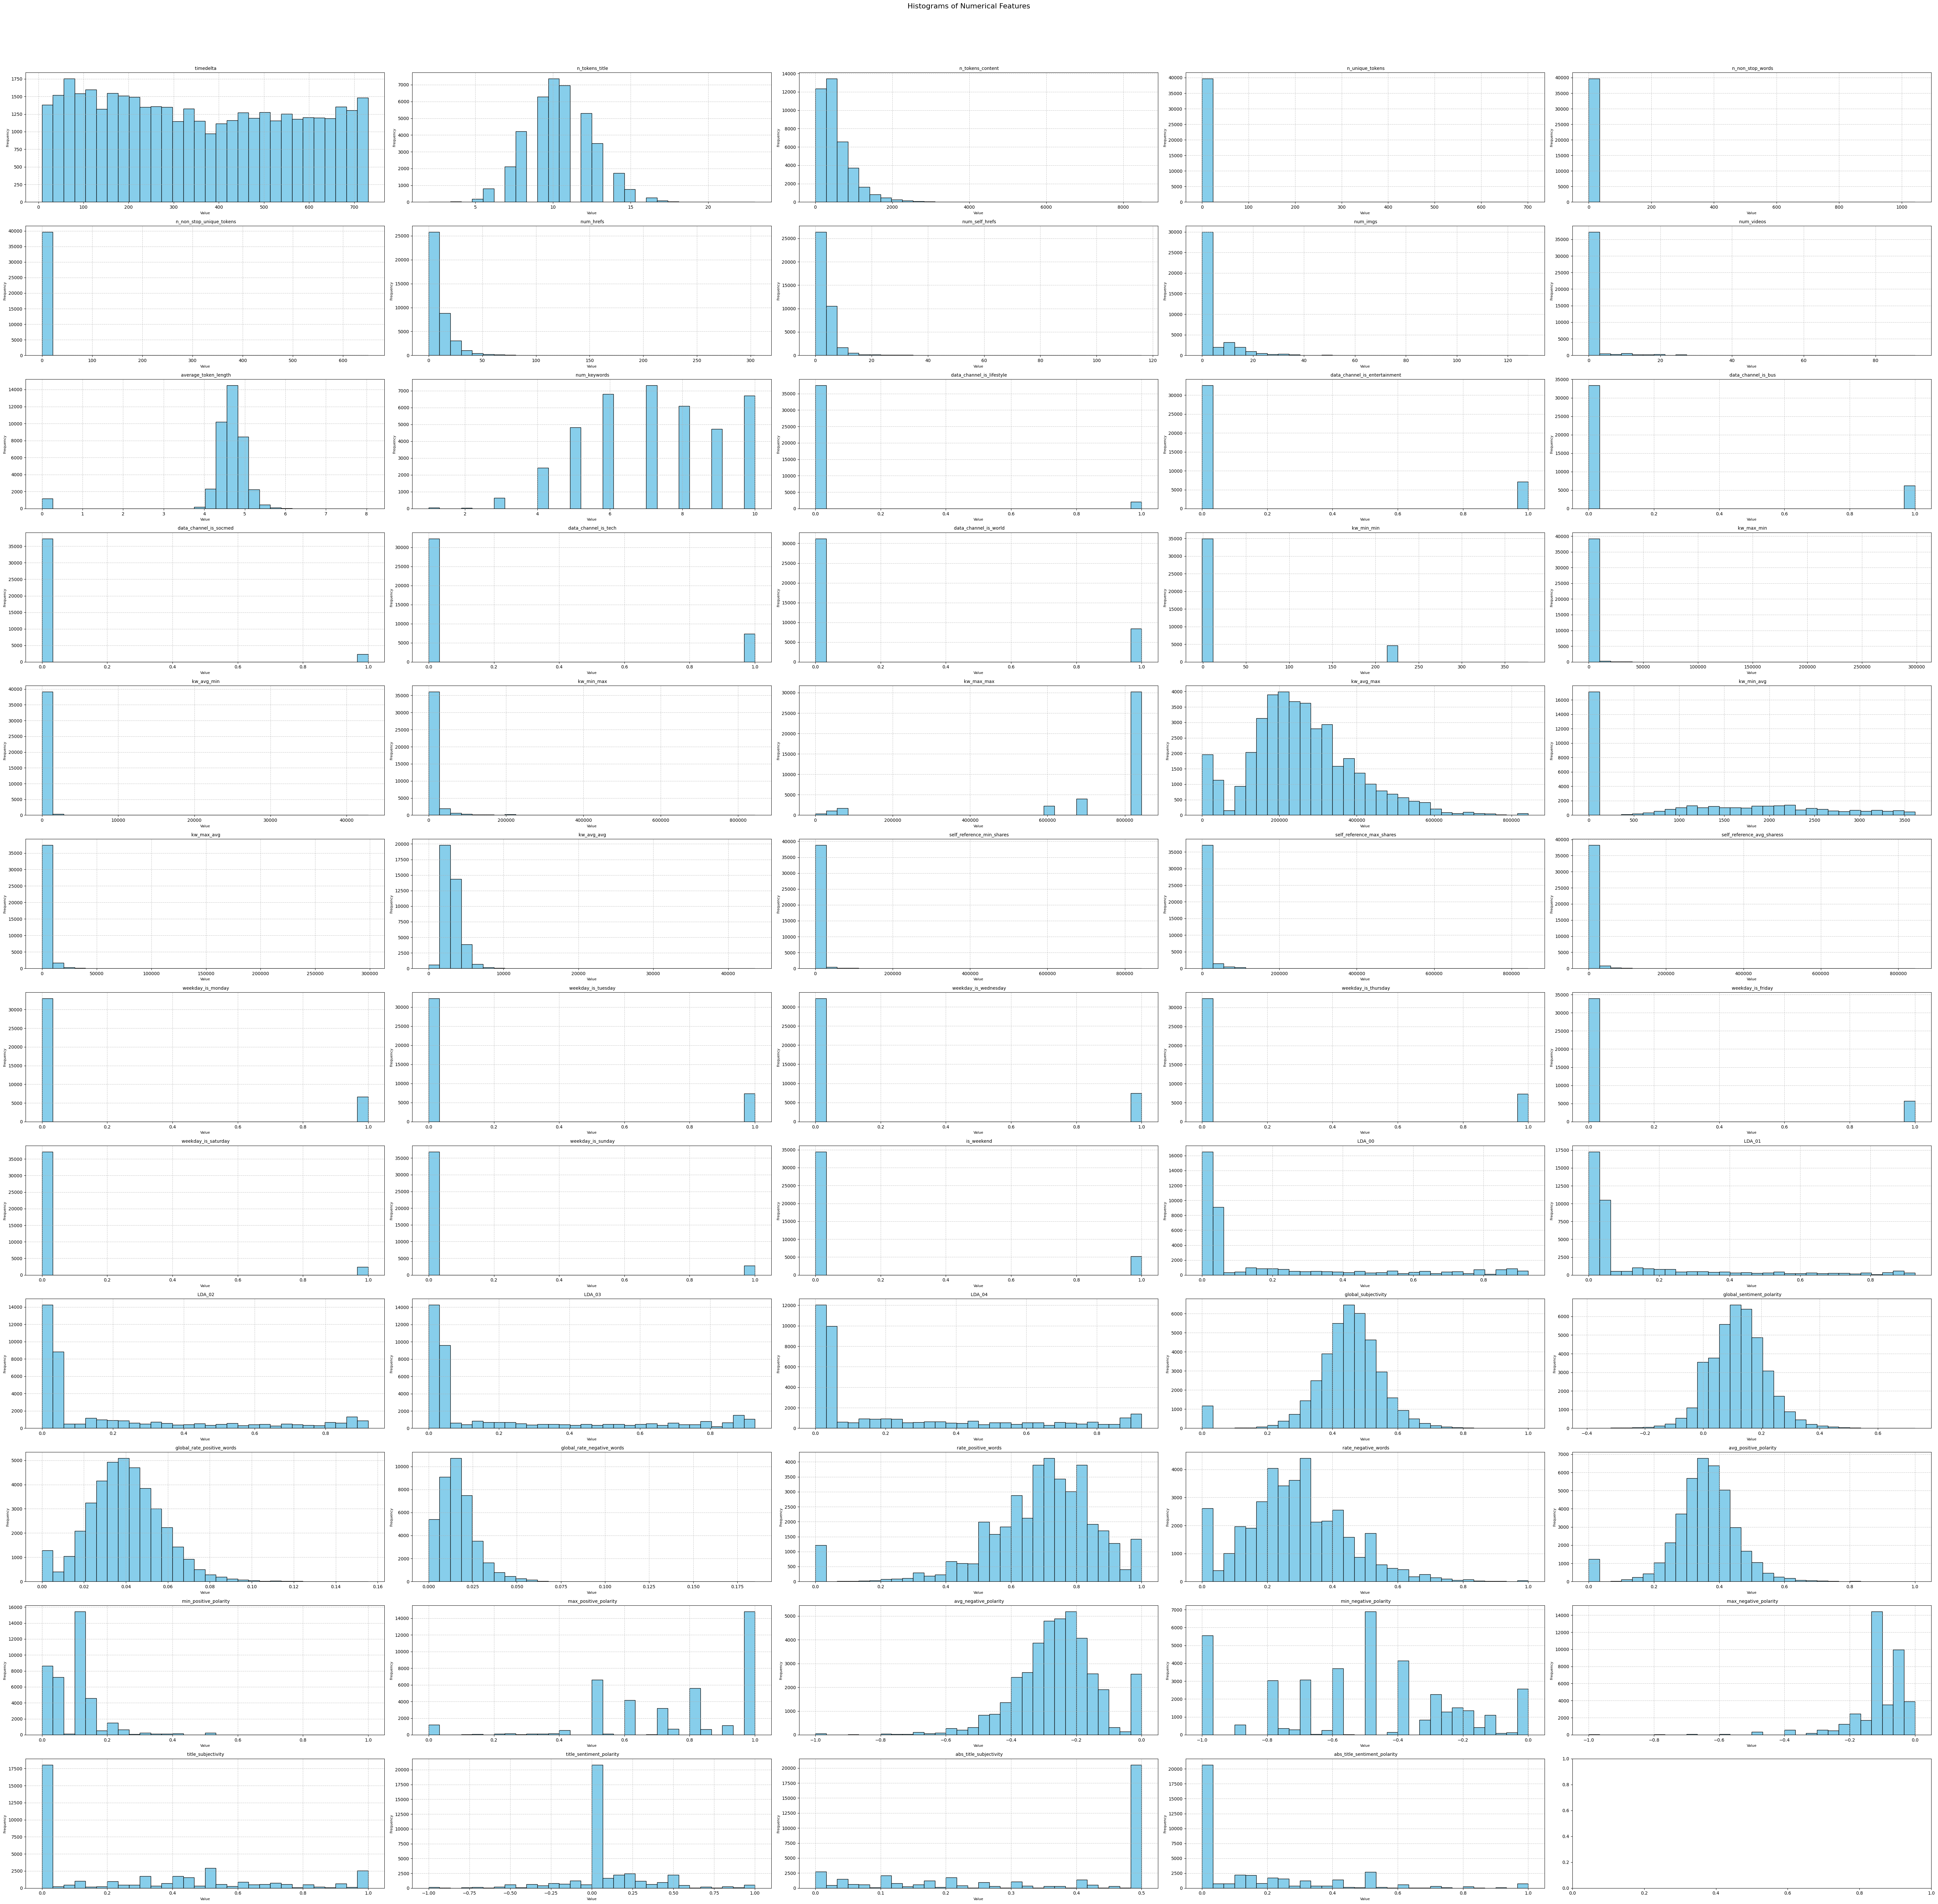

In [32]:
# Subplot settings
num_cols = 5
num_features = len(news_pop.columns)
num_rows = int(np.ceil(num_features / num_cols))

fig, axes = plt.subplots(num_rows, num_cols, figsize=(60, 60))

# Flatten the grid for easier indexing
axes = axes.flatten()  

# Features' histogram
for i, col in enumerate(news_pop.iloc[:,:-1].columns):
    ax = axes[i]
    ax.hist(news_pop[col], bins=30, color='skyblue', edgecolor='black')
    ax.set_title(col, fontsize=10)
    ax.set_xlabel('Value', fontsize=8)
    ax.set_ylabel('Frequency', fontsize=8)
    ax.grid(True, linestyle='--', alpha=0.7)


plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for suptitle
plt.suptitle("Histograms of Numerical Features", fontsize=16)
plt.show()

**Target Distribution: Shares**

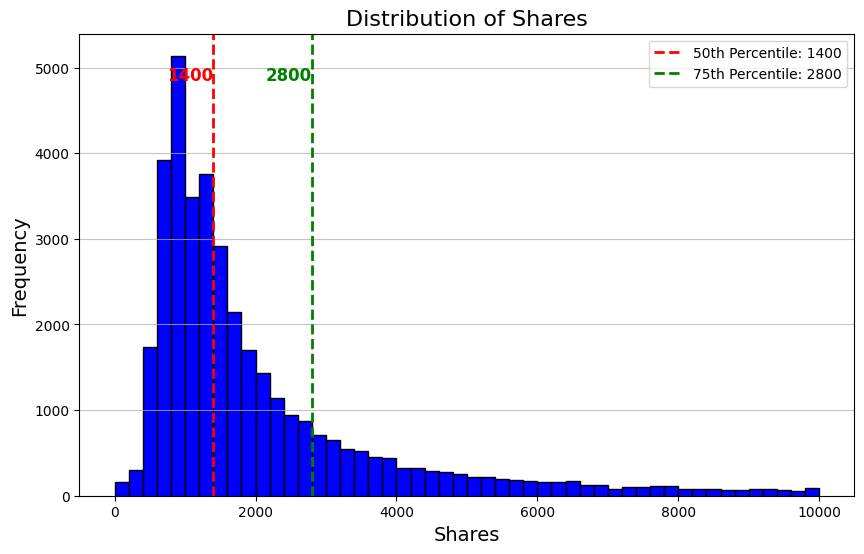

In [24]:
# Calculate percentiles
p50 = np.percentile(news_pop[' shares'], 50)  # Median (50th percentile)
p75 = np.percentile(news_pop[' shares'], 75)  # 75th percentile


plt.figure(figsize=(10, 6))
plt.hist(news_pop[' shares'], bins=50, color='blue', edgecolor='black', range=(0, 10000))  # Limit x-axis to 10,000 shares

# Add percentile dashed lines
plt.axvline(p50, color='red', linestyle='dashed', linewidth=2, label=f'50th Percentile: {p50:.0f}')
plt.axvline(p75, color='green', linestyle='dashed', linewidth=2, label=f'75th Percentile: {p75:.0f}')

# Display percentile values as text on the plot
plt.text(p50, plt.ylim()[1] * 0.9, f'{p50:.0f}', color='red', fontsize=12, ha='right', fontweight='bold')
plt.text(p75, plt.ylim()[1] * 0.9, f'{p75:.0f}', color='green', fontsize=12, ha='right', fontweight='bold')

plt.title('Distribution of Shares', fontsize=16)
plt.xlabel('Shares', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', alpha=0.75)
plt.legend()
plt.show()

**Relationship between features and target**

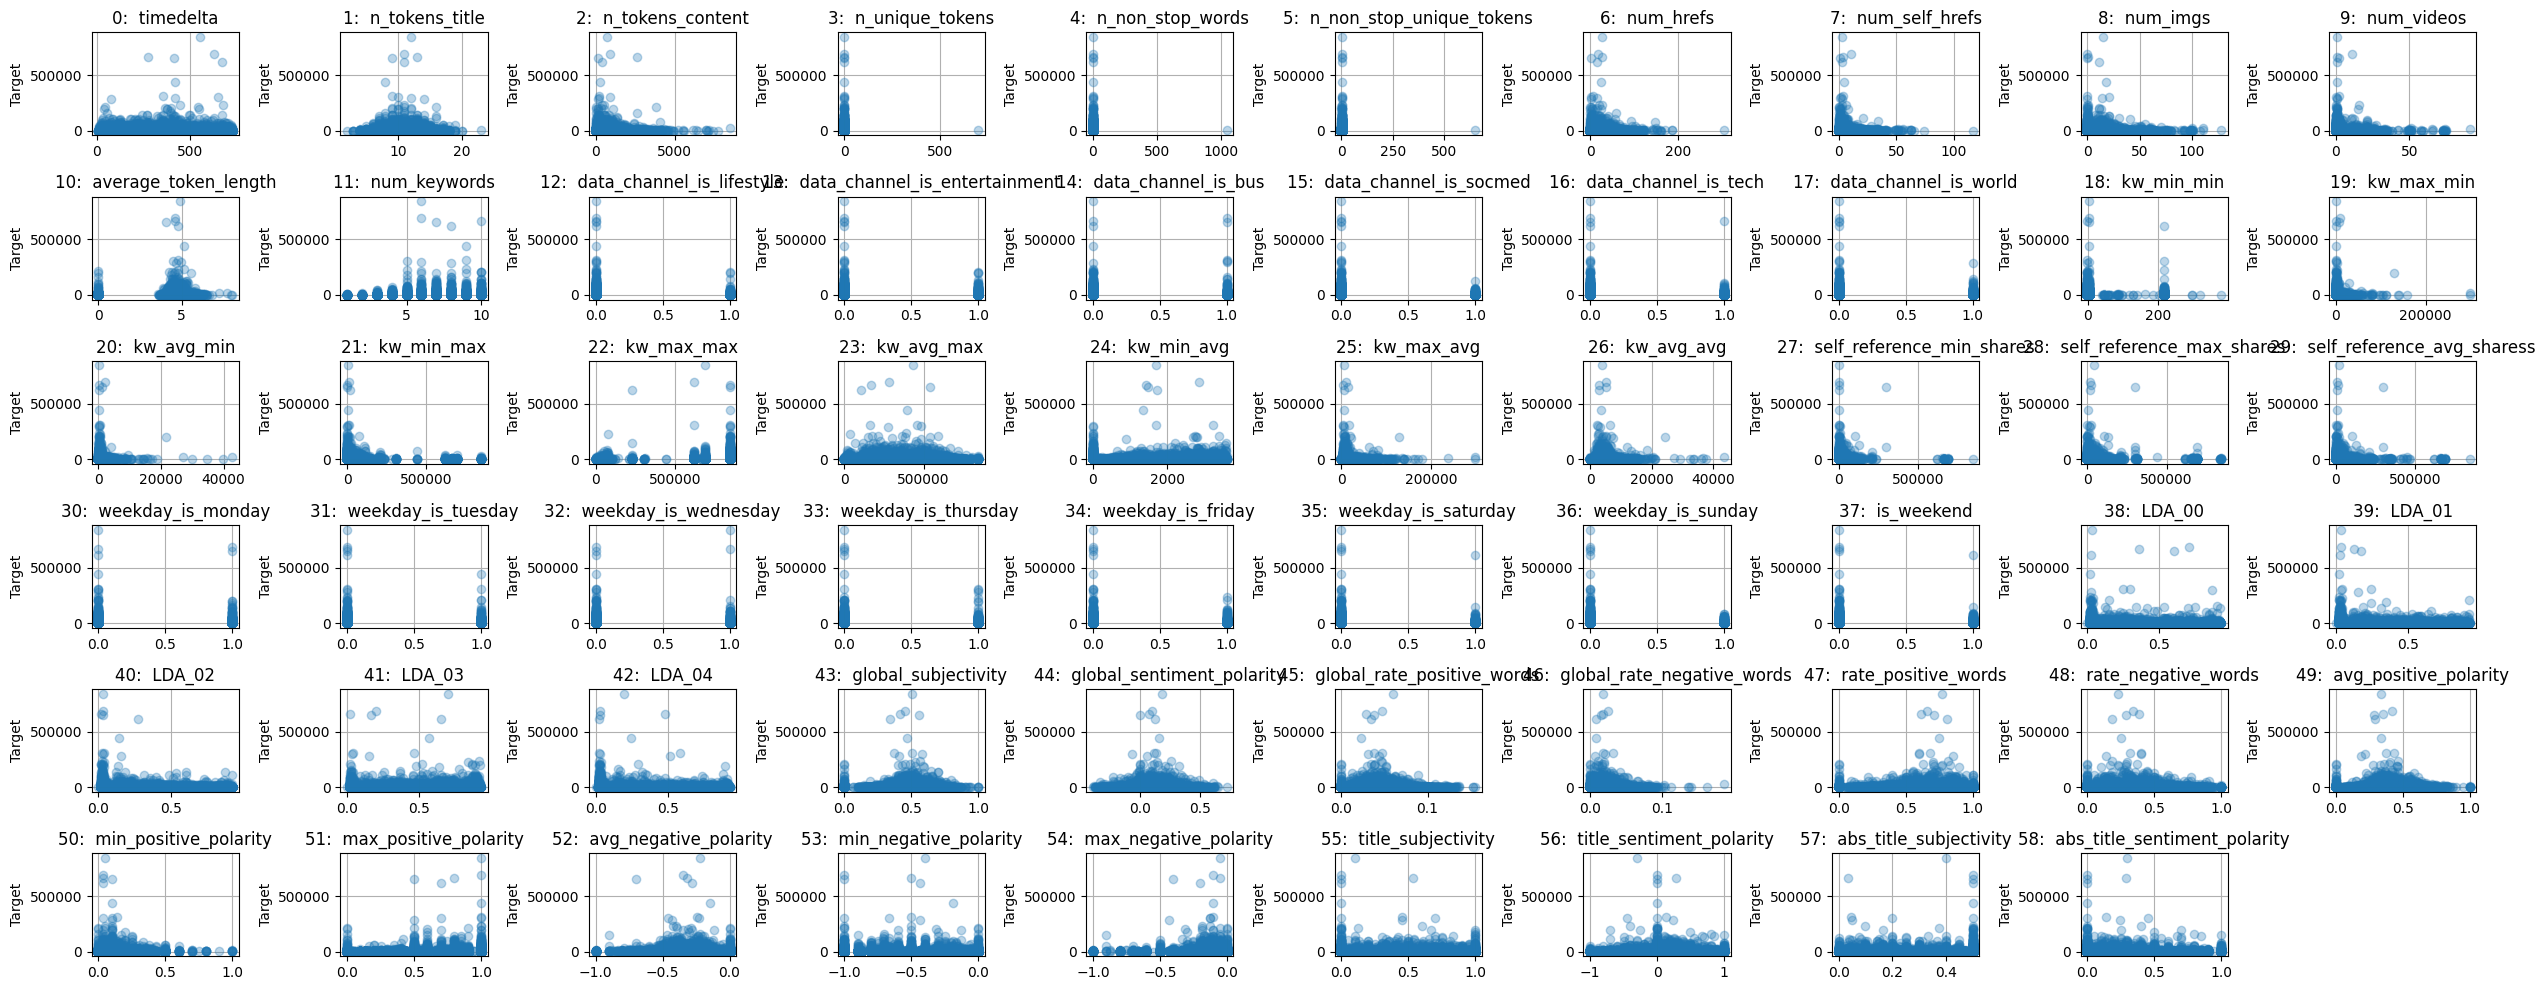

In [37]:
fig, axes = plt.subplots(6, 10, figsize=(25, 10 )) 
for i, ax in enumerate(axes.ravel()):
    if i >= len(news_pop.columns) - 1:  # Exclude the last column if it is the target
        ax.set_visible(False)
        continue
   
    # Plot feature vs target
    ax.plot(news_pop.iloc[:, i], news_pop.iloc[:, -1], 'o', alpha=0.3)
    ax.set_title(f"{i}: {news_pop.columns[i]}")
    ax.set_ylabel("Target")  # Replace with the actual target column name if known
    ax.grid(True)

plt.tight_layout()
plt.show()

**Correlation Analysis**

In [39]:
# Correlation Matrix
corr_matrix = news_pop.corr()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/cluster/hierarchy.py:833: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


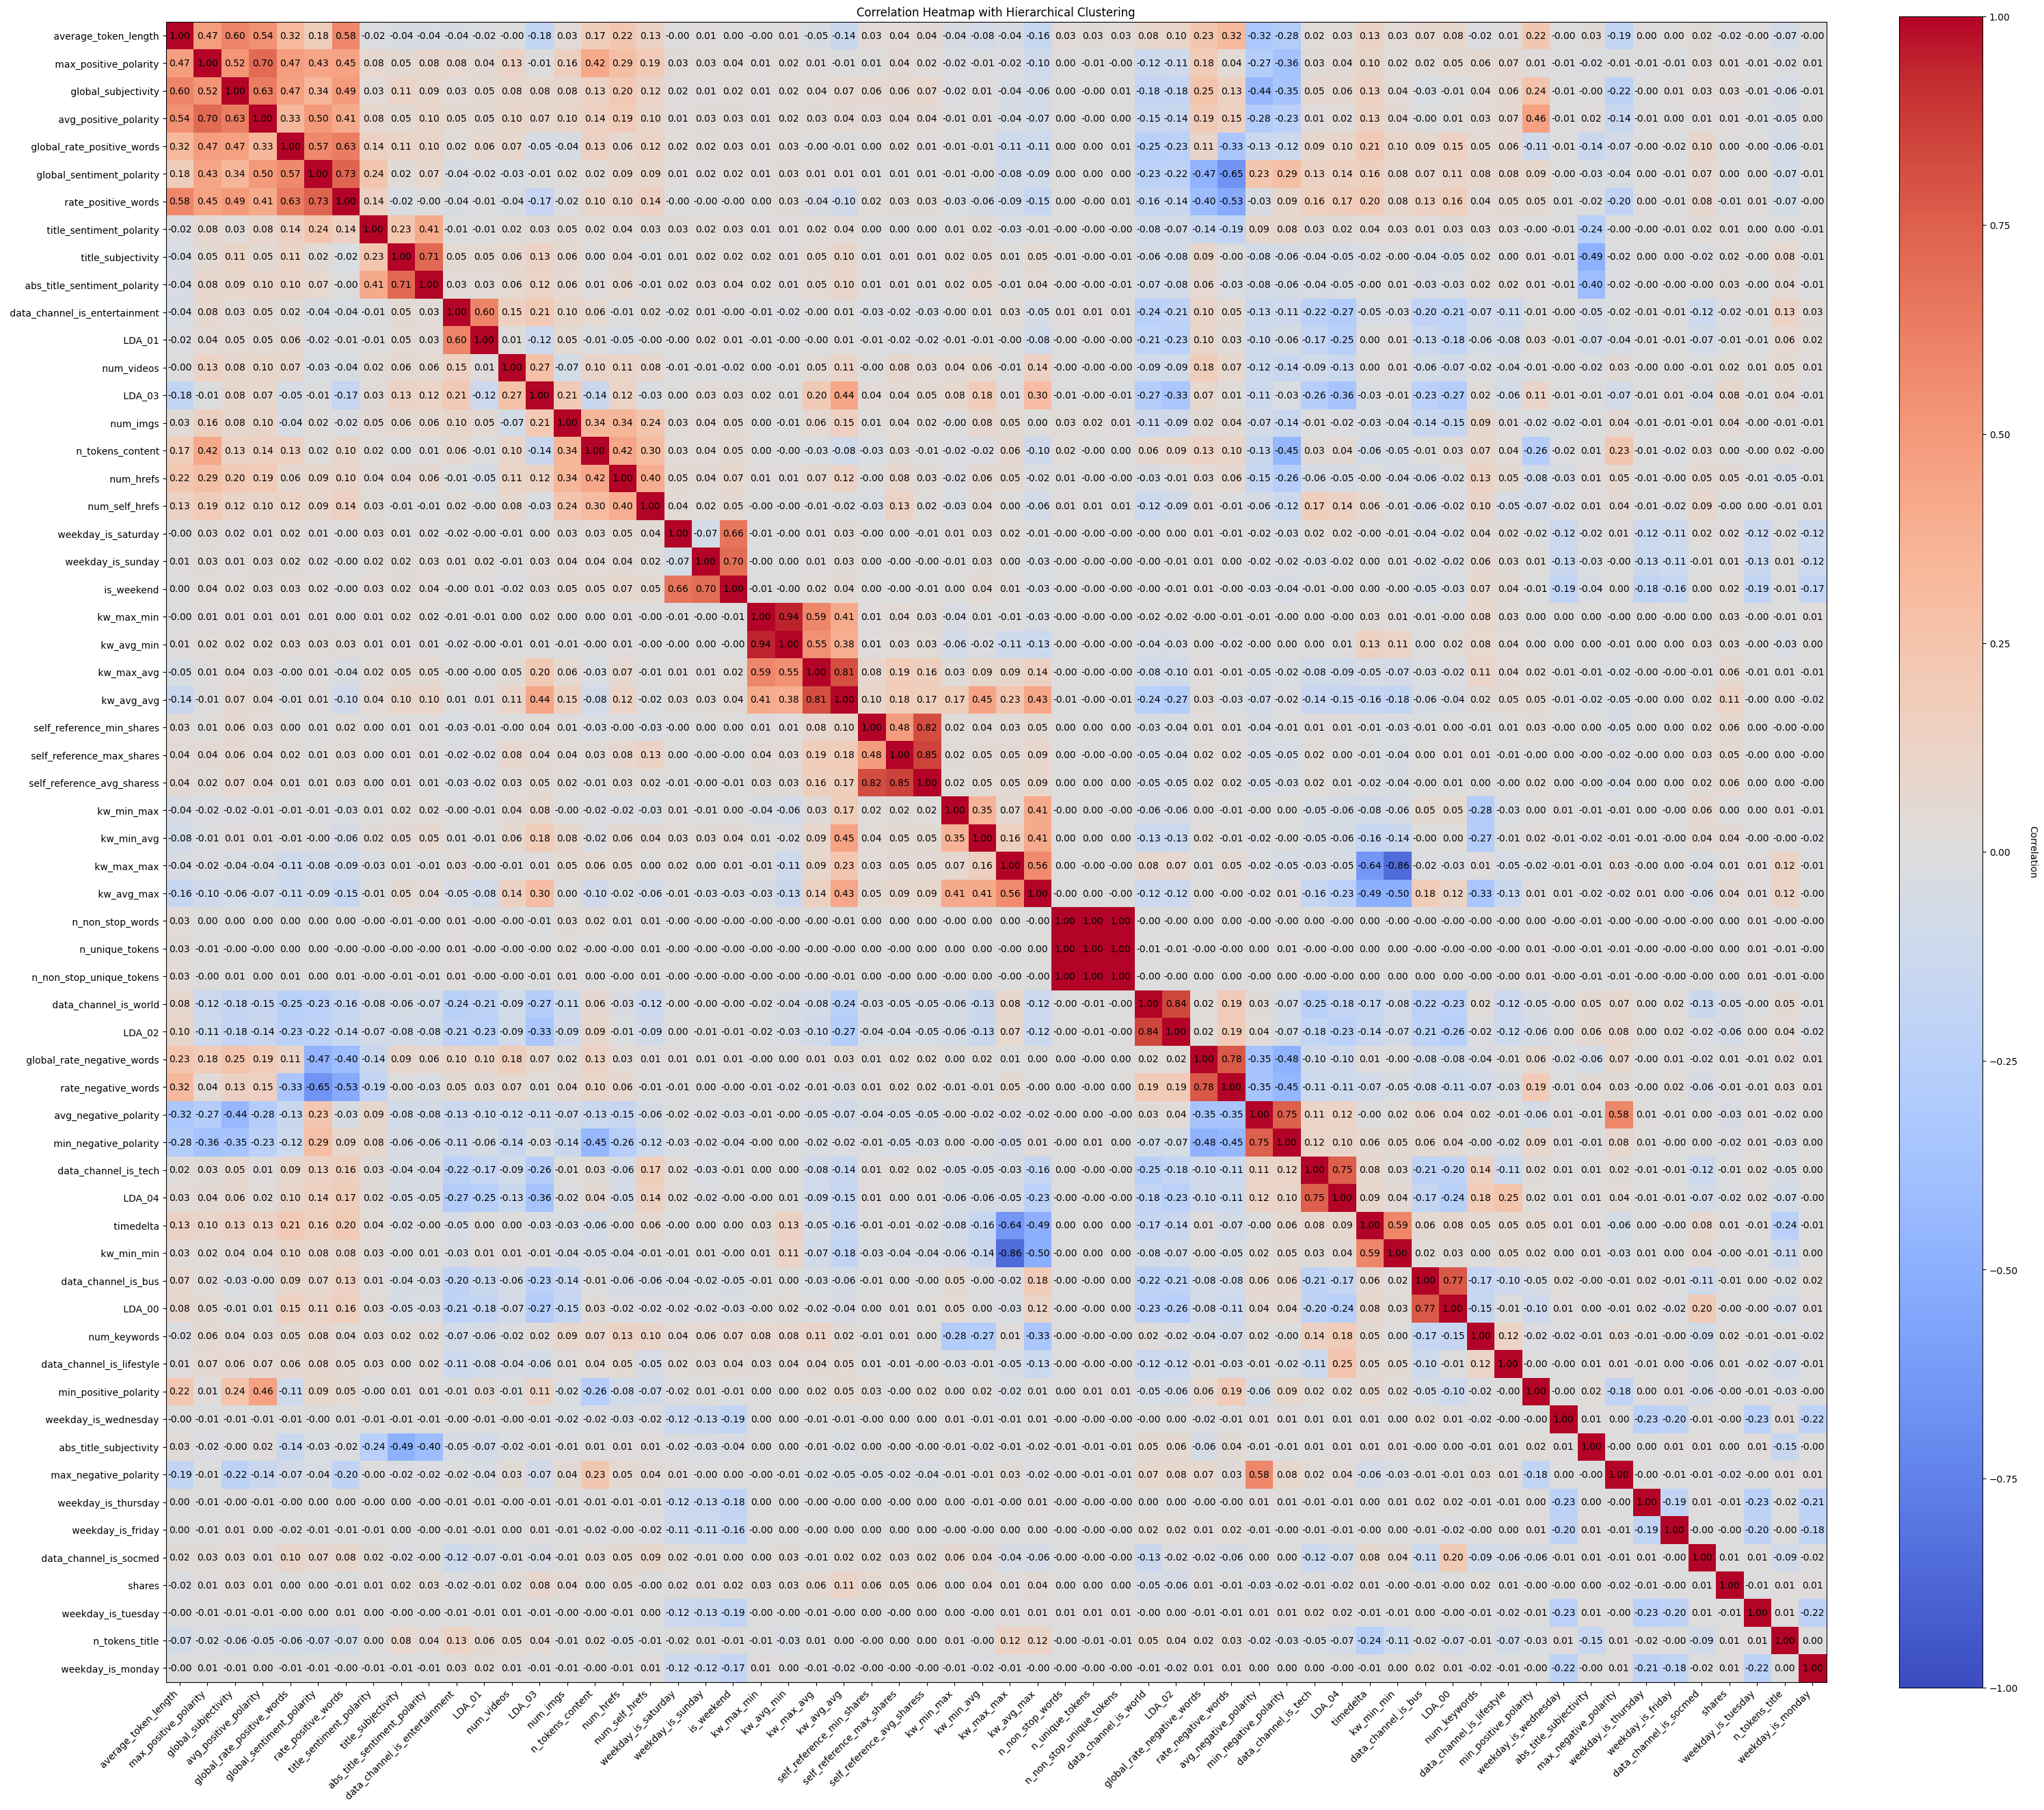

In [41]:
# Hierarchical clustering & get the order of features
order = np.array(hierarchy.dendrogram(
    hierarchy.ward(1 - corr_matrix), no_plot=True)['ivl'], dtype="int")

# Reorder the correlation matrix based on the clustering
reordered_corr = corr_matrix.iloc[order, order]

# Heatmap
plt.figure(figsize=(30, 30))

im = plt.imshow(reordered_corr, cmap="coolwarm", vmin=-1, vmax=1)  # Correlation range [-1, 1]
plt.xticks(range(len(reordered_corr.columns)), reordered_corr.columns, rotation=45, ha="right")
plt.yticks(range(len(reordered_corr.columns)), reordered_corr.columns)

cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
cbar.ax.set_ylabel('Correlation', rotation=270, labelpad=20)

for i in range(len(reordered_corr.columns)):
    for j in range(len(reordered_corr.columns)):
        plt.text(j, i, f"{reordered_corr.iloc[i, j]:.2f}",
                 ha="center", va="center", color="black")

plt.tight_layout()
plt.title("Correlation Heatmap with Hierarchical Clustering")
plt.show()


In [17]:
# Correlation between features and target (V)
target_corr = corr_matrix[' shares']
print(target_corr.head(5))

 timedelta           0.008662
 n_tokens_title      0.008783
 n_tokens_content    0.002459
 n_unique_tokens     0.000806
 n_non_stop_words    0.000443
Name:  shares, dtype: float64


In [18]:
higher_correlated_features = target_corr[abs(target_corr) > 0.1].index
print("Features higher correlated to target:", higher_correlated_features)

Features higher correlated to target: Index([' kw_avg_avg', ' shares'], dtype='object')


## 2.2 Preprocessing & Feature Engineering
Advanced Feature Processing: Clustering


### 2.2.1 K-Means Clustering Attempt

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.1

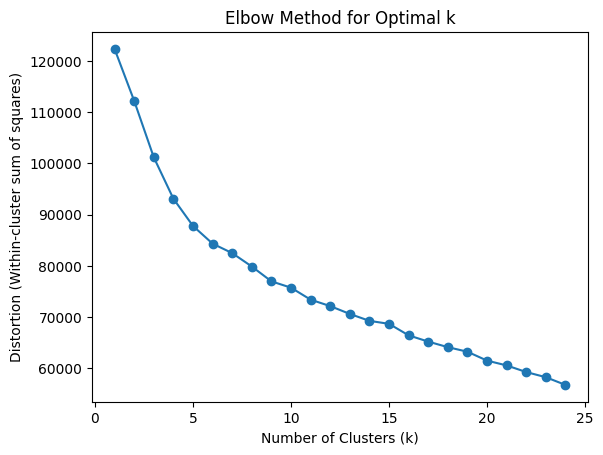

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


          timedelta   n_tokens_title   n_tokens_content   n_unique_tokens  \
Cluster                                                                     
0        335.713689        10.959098         636.097663          0.546993   
1        292.224215        10.452274         604.042921          0.513409   
2        377.896435        10.286927         506.309847          0.552986   
3        391.853774        10.128706         483.752695          0.577976   
4        379.112542        10.209492         552.654915          0.534618   
5        386.257539        10.317855         512.265199          0.553806   
6        287.840156        10.645874         607.679012          0.511305   
7        392.762480        10.306763         579.374396          0.530425   
8        432.338822         9.739709         612.955668          0.530981   
9        289.154188        10.427724         587.398073          0.517869   
10       351.970817        10.447471         700.569390          0.507118   

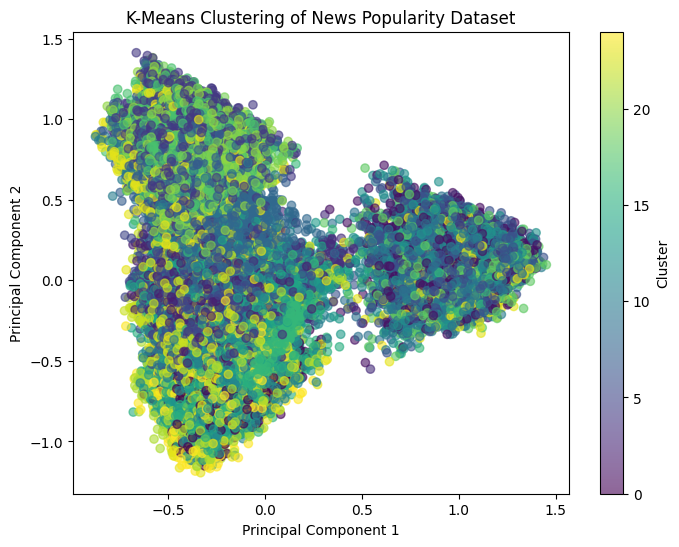

Cluster centers:
[[0.45326928 0.42662374 0.07506463 ... 0.64556902 0.1705913  0.00343519]
 [0.39311786 0.40248925 0.07128191 ... 0.7290075  0.11593366 0.00281448]
 [0.51161333 0.39461557 0.05974862 ... 0.7011132  0.13886002 0.00347747]
 ...
 [0.50940455 0.39236958 0.0652378  ... 0.67416796 0.13253425 0.00463018]
 [0.47629519 0.39418988 0.07402161 ... 0.66351391 0.16747778 0.00480355]
 [0.50919827 0.40072428 0.06063921 ... 0.60180073 0.21992059 0.00496696]]


In [14]:
X_kmeans = news_pop.copy()
X_kmeans_scaled = MinMaxScaler().fit_transform(X_kmeans)

# Elbow method to determine the optimal number of clusters
distortions = []
for k in range(1, 25):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_kmeans_scaled)
    distortions.append(kmeans.inertia_)

plt.plot(range(1,25), distortions, marker='o')
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Distortion (Within-cluster sum of squares)")
plt.show()


# Apply KMeans with 3 clusters (chosen from elbow/silhouette analysis)
kmeans = KMeans(n_clusters=25, random_state=42)
kmeans.fit(X_kmeans_scaled)

# Add the cluster labels to the original data
news_pop['Cluster'] = kmeans.labels_

# Inspect the clusters
print(news_pop.groupby('Cluster').mean())  # Find the average values of each feature in each cluster

# For 2D visualization, you can use PCA for dimensionality reduction
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_kmeans_scaled)

# Plot the clusters
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans.labels_, cmap='viridis', alpha=0.6)
plt.title("K-Means Clustering of News Popularity Dataset")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label='Cluster')
plt.show()

print("Cluster centers:")
print(kmeans.cluster_centers_)


### 2.2.2 DBSCAN (Density-Based Spatial Clustering of Applications with Noise) 

In [15]:
X_DBSCAN = news_pop.copy()

X_scaled_DBSCAN = MinMaxScaler().fit_transform(X_DBSCAN)

# Adjust eps and min_samples according to the dataset characteristics
dbscan = DBSCAN(eps=0.0002, min_samples=5)
clusters = dbscan.fit_predict(X_scaled_DBSCAN)

# Analyze the clustering results:
# Dataset with a new column containing the clustering results
X_DBSCAN_analysis = news_pop.copy()
X_DBSCAN_analysis['Cluster'] = clusters

# Group by clusters and calculate the mean of the features within each cluster
cluster_means = X_DBSCAN_analysis.groupby('Cluster').mean()
print(cluster_means)

# Identify noise points (labelled as -1 by DBSCAN)
noise_points = X_DBSCAN_analysis[X_DBSCAN_analysis['Cluster'] == -1]
print(f"Number of noise points: {len(noise_points)}")


          timedelta   n_tokens_title   n_tokens_content   n_unique_tokens  \
Cluster                                                                     
-1       354.530471        10.398749         546.514731          0.548216   

          n_non_stop_words   n_non_stop_unique_tokens   num_hrefs  \
Cluster                                                             
-1                0.996469                   0.689175    10.88369   

          num_self_hrefs   num_imgs   num_videos  ...   min_positive_polarity  \
Cluster                                           ...                           
-1              3.293638   4.544143     1.249874  ...                0.095446   

          max_positive_polarity   avg_negative_polarity  \
Cluster                                                   
-1                     0.756728               -0.259524   

          min_negative_polarity   max_negative_polarity   title_subjectivity  \
Cluster                                                   

## 2.3 Model Selection & Training

### Determine the popularity threshold

In [108]:
# Determine popoularity threshold. 
# Shares >= 1400 is defined as popular.
median_threshold = news_pop[' shares'].median()
percentile_75_threshold = news_pop[' shares'].quantile(0.75)

print(f"Median as Threshold: {median_threshold}")
print(f"75th Percentile as Threshold: {percentile_75_threshold}")

print("Use the median of shares as the threshold:\n")

# Create a new column 'pop_level' of type of string.
news_pop_copy = news_pop.copy()
news_pop_copy['pop_level'] = news_pop_copy[' shares'].apply(lambda x: 'Popular' if x >= 1400 else 'Not Popular')

x = news_pop_copy.drop([' shares', 'pop_level'], axis=1)
y = news_pop_copy['pop_level']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Counts of "Popular" and "Not Popular"
popularity_counts = news_pop_copy['pop_level'].value_counts()
print(popularity_counts)

Median as Threshold: 1400.0
75th Percentile as Threshold: 2800.0
Use the median of shares as the threshold:

pop_level
Popular        21154
Not Popular    18490
Name: count, dtype: int64


### 2.3.1 Models Fitted with Original Data
1. LinearSVC
2. Logitic Regression
3. Random Forest with full features
4. Random Forest with data after feature selection 
   - Keep the top 50% important features
   - Keep the top 60% important features (Best)


#### 2.3.1.1 LinearSVC Using Original data

In [ ]:
SVC_pipe = Pipeline([("Scaler", "passthrough"),  ("Classifier", LinearSVC(dual=False, max_iter=5000)) ])

param_grid_SVC = {
    "Scaler": [StandardScaler(), MinMaxScaler(),'passthrough'],
    "Classifier__C": np.logspace(-6, 6, num=13) }

SVC_original_grid = GridSearchCV(SVC_pipe, param_grid_SVC, cv=10, n_jobs=-1)
SVC_original_grid.fit(x_train, y_train)

results = pd.DataFrame(SVC_original_grid.cv_results_)

# Best Parameters for the Best Estimator
print("\nBest Parameters:", SVC_original_grid.best_params_)
print("Best Estimator:", SVC_original_grid.best_estimator_)

# Accuracy 
print("Training Score (accuracy) of Best Estimator):{:.4f}".format(SVC_original_grid.best_score_))
print("Test Score (accuracy) of Best Estimator :{:.4f}".format(SVC_original_grid.score(x_test, y_test)))

# Fit the best estimator to the all training data
best_estimator_SVC = SVC_original_grid.best_estimator_.fit(x_train, y_train)

print("\n=== Evaluation: LinearSVC with Original Data ===")

# Precision / Recall / F1-score
print("Classification report:\n{}".format(classification_report(y_test, best_estimator_SVC.predict(x_test), digits=4)))

# Micro-average precision, recall
micro_precision = precision_score(y_test, best_estimator_SVC.predict(x_test), average='micro')
micro_recall = recall_score(y_test, best_estimator_SVC.predict(x_test), average='micro')

print("Micro-average Precision: {:.4f}".format(micro_precision))
print("Micro-average Recall: {:.4f}".format(micro_recall))


Best Parameters: {'Classifier__C': 1.0, 'Scaler': StandardScaler()}
Best Estimator: Pipeline(steps=[('Scaler', StandardScaler()),
                ('Classifier', LinearSVC(dual=False, max_iter=5000))])
Training Score (accuracy) of Best Estimator):0.6538
Test Score (accuracy) of Best Estimator :0.6525

=== Evaluation: LinearSVC with Original Data ===
Classification report:
              precision    recall  f1-score   support

 Not Popular     0.6438    0.6044    0.6235      3774
     Popular     0.6596    0.6963    0.6774      4155

    accuracy                         0.6525      7929
   macro avg     0.6517    0.6503    0.6505      7929
weighted avg     0.6521    0.6525    0.6518      7929

Micro-average Precision: 0.6525
Micro-average Recall: 0.6525


#### 2.3.1.2 Logistic Regression Using Original data

In [ ]:
logreg_pipeline = make_pipeline(StandardScaler(), LogisticRegression(dual=False, solver='saga', max_iter=5000))

logreg_param_grid = {'standardscaler': [StandardScaler(), MinMaxScaler(), 'passthrough'],
                     'logisticregression__C': [0.01, 0.1, 1, 10, 100]}

logreg_original_grid = GridSearchCV(logreg_pipeline, logreg_param_grid, cv=5, n_jobs=-1)
logreg_original_grid.fit(x_train, y_train)

print("\n=== Logistic Regression with Original Data ===")

# Best Parameters for the Best Estimator
print("Best Parameters:", logreg_original_grid.best_params_)
print("Best Estimator:", logreg_original_grid.best_estimator_)

# Accuracy
print("Test Score (accuracy) of Best Estimator :{:.4f}".format(logreg_original_grid.best_score_))
print("Test Score (accuracy) of Best Estimator :{:.4f}".format(logreg_original_grid.score(x_test, y_test)))

# Best model from original data
logreg_original_best_model = logreg_original_grid.best_estimator_
y_pred_logreg_original = logreg_original_best_model.predict(x_test)

print("\n=== Evaluation: Logistic Regression with Original Data ===")

print("Classification Report:\n", classification_report(y_test, y_pred_logreg_original, digits=4))
# Micro-average precision, recall
micro_precision = precision_score(y_test, y_pred_logreg_original, average='micro')
micro_recall = recall_score(y_test, y_pred_logreg_original, average='micro')

print("Micro-average Precision: {:.4f}".format(micro_precision))
print("Micro-average Recall: {:.4f}".format(micro_recall))


=== Logistic Regression with Original Data ===
Best Parameters: {'logisticregression__C': 1, 'standardscaler': StandardScaler()}
Best Estimator: Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=1, max_iter=5000, solver='saga'))])
Test Score (accuracy) of Best Estimator :0.6541
Test Score (accuracy) of Best Estimator :0.6522

=== Evaluation: Logistic Regression with Original Data ===
Confusion Matrix:
 [[2261 1513]
 [1245 2910]]
Classification Report:
               precision    recall  f1-score   support

 Not Popular     0.6449    0.5991    0.6212      3774
     Popular     0.6579    0.7004    0.6785      4155

    accuracy                         0.6522      7929
   macro avg     0.6514    0.6497    0.6498      7929
weighted avg     0.6517    0.6522    0.6512      7929

Micro-average Precision: 0.6522
Micro-average Recall: 0.6522


#### 2.3.1.3 Random Forest Using Original data

In [112]:
pipeline_rf = Pipeline([
    ('scaler', 'passthrough'),
    ('classifier', RandomForestClassifier(random_state=42))])

param_grid_rf = {
    'classifier__n_estimators': [5, 10, 50, 100],  
    'classifier__max_depth': [5, 10, 20],
    'classifier__max_features': ['sqrt', 'log2']}

rf_original_grid = GridSearchCV(estimator=pipeline_rf, param_grid=param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
rf_original_grid.fit(x_train, y_train)

# Best parameters and scores
print("Best Parameters:", rf_original_grid.best_params_)
print("Best Estimator:", rf_original_grid.best_estimator_)


print("Best Cross-Validation Accuracy: {:.4f}".format(rf_original_grid.best_score_))
print("Test Score (accuracy) of Best Estimator :{:.4f}".format(rf_original_grid.score(x_test, y_test)))

# Predict on the test set
y_test_pred_rf_orig = rf_original_grid.best_estimator_.predict(x_test)

print("\n=== Evaluation: Random Forest with Original Data ===")

# Generate a classification report
print("\n=== Classification Report ===")
print(classification_report(y_test, y_test_pred_rf_orig, digits=4))

# Micro-average precision, recall
micro_precision = precision_score(y_test, y_test_pred_rf_orig, average='micro')
micro_recall = recall_score(y_test, y_test_pred_rf_orig, average='micro')
print("Micro-average Precision: {:.4f}".format(micro_precision))
print("Micro-average Recall: {:.4f}".format(micro_recall))


Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Parameters: {'classifier__max_depth': 10, 'classifier__max_features': 'sqrt', 'classifier__n_estimators': 100}
Best Estimator: Pipeline(steps=[('scaler', 'passthrough'),
                ('classifier',
                 RandomForestClassifier(max_depth=10, random_state=42))])
Best Cross-Validation Accuracy: 0.6685
Test Score (accuracy) of Best Estimator :0.6674

=== Evaluation: Random Forest with Original Data ===

=== Classification Report ===
              precision    recall  f1-score   support

 Not Popular     0.6753    0.5803    0.6242      3774
     Popular     0.6620    0.7466    0.7017      4155

    accuracy                         0.6674      7929
   macro avg     0.6686    0.6634    0.6630      7929
weighted avg     0.6683    0.6674    0.6648      7929

Micro-average Precision: 0.6674
Micro-average Recall: 0.6674


#### 2.3.1.4 Random Forest with data after feature selection 
   - Keep the top 50% important features
   - Keep the top 60% important features (Best)

**2.3.1.4.1 Keep the top 50% important features:**

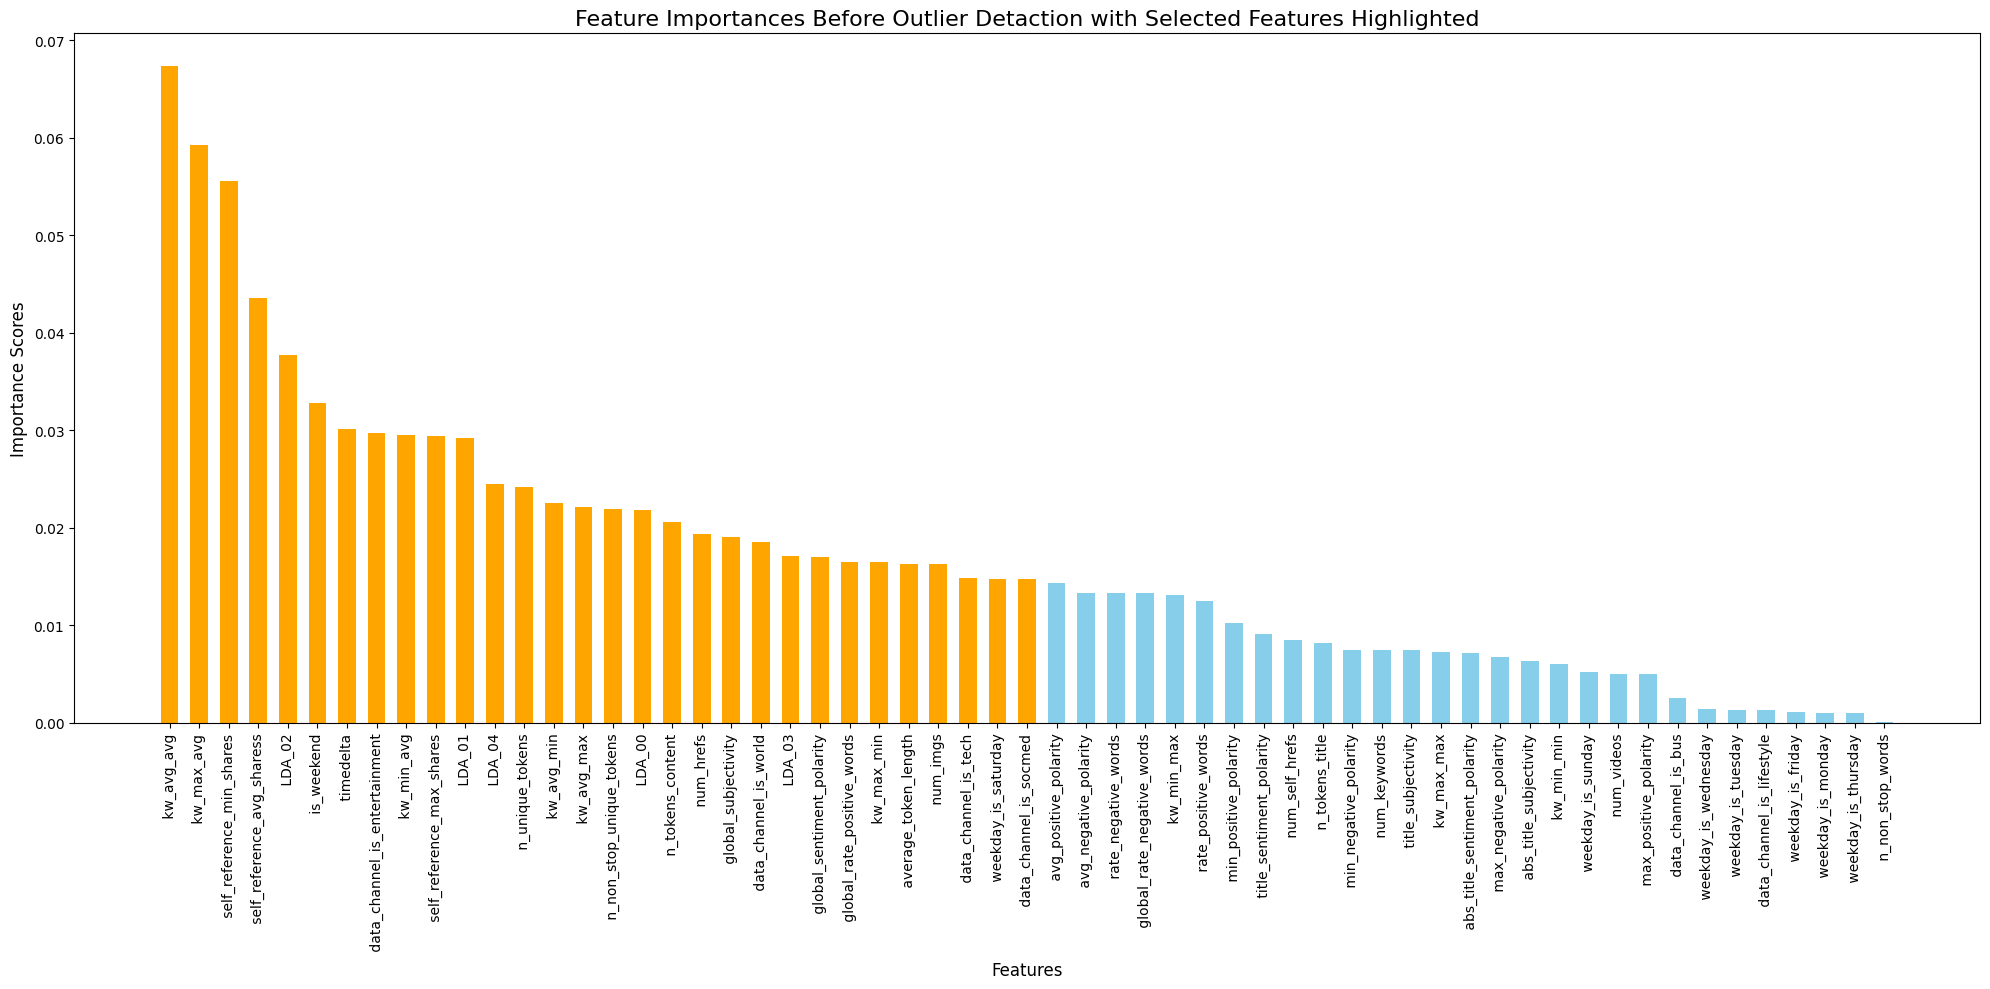

In [114]:
rf_org = rf_original_grid.best_estimator_.named_steps['classifier']
feature_importances_rf_org = rf_org.feature_importances_

# Extract the feature importances and selected feature names
all_features_org = x_train.columns  # Original feature names
selector_rf_org = SelectFromModel(estimator=rf_org, threshold="median", prefit=True)

# Boolean mask of selected features: True -> selected features, False -> otherwise
selected_features_mask = selector_rf_org.get_support()  

# Compare all features and selected features
feature_comparison_df = pd.DataFrame({
    'Feature': all_features_org,
    'Importance': feature_importances_rf_org,
    'Selected': selected_features_mask 
})

# Sort features by importance
feature_comparison_df = feature_comparison_df.sort_values(by='Importance', ascending=False)

# Plot all features with the selected ones highlighted
plt.figure(figsize=(20, 10))
bar_width = 0.6
x_positions = np.arange(len(feature_comparison_df))


plt.bar(
    x_positions, 
    feature_comparison_df['Importance'], 
    color=np.where(feature_comparison_df['Selected'], 'orange', 'skyblue'), 
    width=bar_width, 
    label='Feature Importance'
)


plt.xticks(x_positions, feature_comparison_df['Feature'], rotation=90, fontsize=10)
plt.ylabel("Importance Scores", fontsize=12)
plt.xlabel("Features", fontsize=12)
plt.title("Feature Importances Before Outlier Detaction with Selected Features Highlighted", fontsize=16)
plt.tight_layout()
plt.show()

In [115]:
# Remove unimportant features and retrain the model

# Get selected features based on feature importance threshold
selected_features_rf_orig_50th = feature_comparison_df[feature_comparison_df['Selected']]['Feature'].values

# Create new training and testing sets with only important features
x_train_selected = x_train[selected_features_rf_orig_50th]
x_test_selected = x_test[selected_features_rf_orig_50th]

pipeline_rf_orig_selected = Pipeline([('classifier', RandomForestClassifier(random_state=42))])

param_grid_rf_selected = {
    'classifier__n_estimators': [5, 10, 50, 100],  
    'classifier__max_depth': [5, 10, 20],
    'classifier__max_features': ['sqrt', 'log2']
    }

grid_selected = GridSearchCV(
    estimator=pipeline_rf_orig_selected, 
    param_grid=param_grid_rf_selected, 
    cv=5, 
    scoring='accuracy', 
    n_jobs=-1, 
    verbose=1)

grid_selected.fit(x_train_selected, y_train)

# Best parameters and scores
print("Best Parameters:", grid_selected.best_params_)
print("Best Estimator:", grid_selected.best_estimator_)

print("Best Cross-Validation Accuracy :{:.4f}".format(grid_selected.best_score_))
print("Test Accuracy :{:.4f}".format(grid_selected.score(x_test_selected, y_test)))

# Predict on the test set
y_test_pred_rf_selected = grid_selected.best_estimator_.predict(x_test_selected)

# Precision / Recall / F-score
print("\n=== Classification Report ===")
print(classification_report(y_test, y_test_pred_rf_selected, digits=4))

# Micro-average precision and recall
micro_precision_selected = precision_score(y_test, y_test_pred_rf_selected, average='micro')
micro_recall_selected = recall_score(y_test, y_test_pred_rf_selected, average='micro')
print("Micro-average Precision :{:.4f}".format(micro_precision_selected))
print("Micro-average Recall :{:.4f}".format(micro_recall_selected))

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Parameters: {'classifier__max_depth': 20, 'classifier__max_features': 'sqrt', 'classifier__n_estimators': 100}
Best Estimator: Pipeline(steps=[('classifier',
                 RandomForestClassifier(max_depth=20, random_state=42))])
Best Cross-Validation Accuracy :0.6697
Test Accuracy :0.6646

=== Classification Report ===
              precision    recall  f1-score   support

 Not Popular     0.6637    0.5988    0.6296      3774
     Popular     0.6653    0.7244    0.6936      4155

    accuracy                         0.6646      7929
   macro avg     0.6645    0.6616    0.6616      7929
weighted avg     0.6646    0.6646    0.6632      7929

Micro-average Precision :0.6646
Micro-average Recall :0.6646


The performance is slightly worse than the model fitted with data with all features

**2.3.1.4.1 Keep the top 60% important features:** 
- using the 40th impotant feature as the threadhold for selection

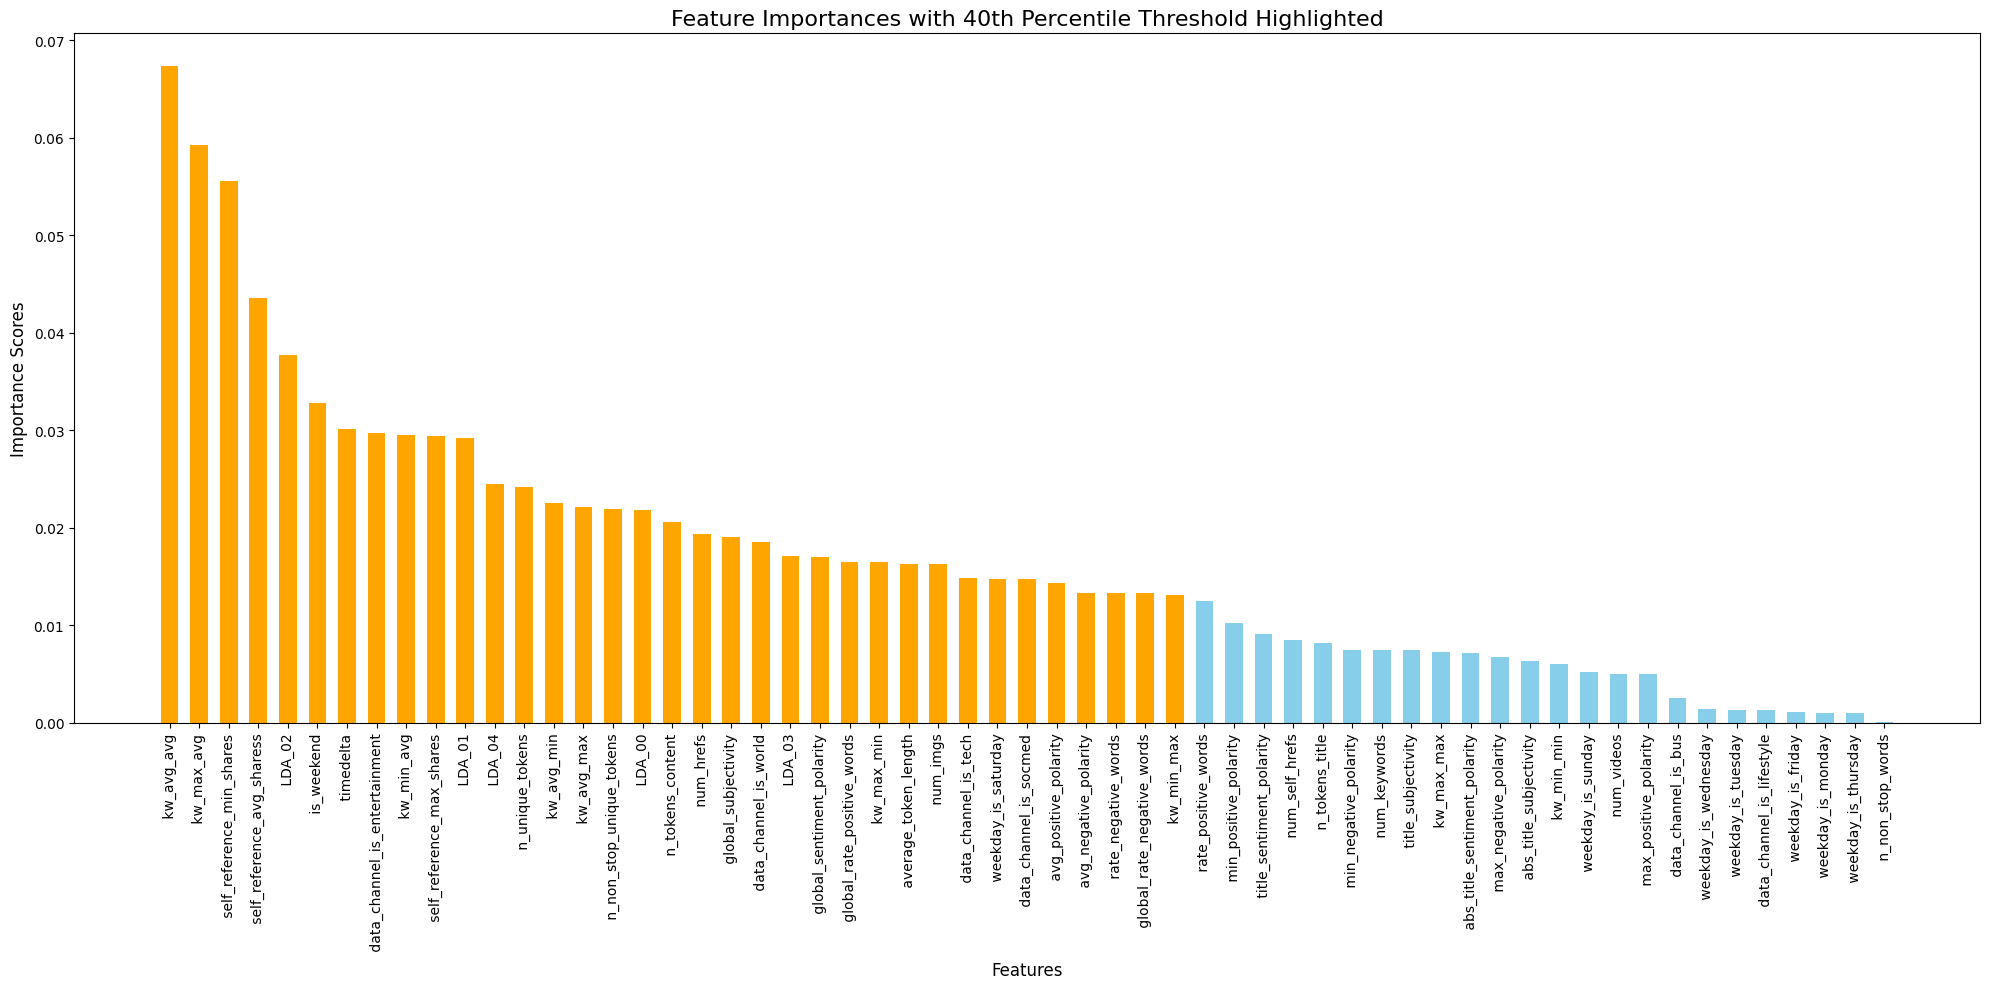

In [116]:
feature_importances_rf_org = rf_org.feature_importances_

# The 40th percentile threshold for feature importance
threshold_40th = np.percentile(feature_importances_rf_org, 40)

# Select features that have importance above the 40th percentile threshold
selected_features_40th = feature_comparison_df[feature_comparison_df['Importance'] >= threshold_40th]['Feature'].values

# Boolean mask for selected features 
feature_comparison_df['Selected_40th'] = feature_comparison_df['Importance'] >= threshold_40th

# Plot feature importances with new selection based on the 40th percentile
plt.figure(figsize=(20, 10))
bar_width = 0.6
x_positions = np.arange(len(feature_comparison_df)) 

plt.bar(
    x_positions, 
    feature_comparison_df['Importance'], 
    color=np.where(feature_comparison_df['Selected_40th'], 'orange', 'skyblue'), 
    width=bar_width, 
    label='Feature Importance'
)

plt.xticks(x_positions, feature_comparison_df['Feature'], rotation=90, fontsize=10)
plt.ylabel("Importance Scores", fontsize=12)
plt.xlabel("Features", fontsize=12)
plt.title("Feature Importances with 40th Percentile Threshold Highlighted", fontsize=16)
plt.tight_layout()
plt.show()


In [128]:
# Selected features based on the 40th percentile threshold
selected_features_rf_orig_40th = feature_comparison_df[feature_comparison_df['Selected_40th']]['Feature'].values

x_train_selected_40th = x_train[selected_features_rf_orig_40th]
x_test_selected_40th = x_test[selected_features_rf_orig_40th]

pipeline_rf_selected_40th = Pipeline([
    ('classifier', RandomForestClassifier(random_state=42))
])

param_grid_rf_selected_40th = {
    'classifier__n_estimators': [5, 10, 50, 100],  
    'classifier__max_depth': [5, 10, 20],
    'classifier__max_features': ['sqrt', 'log2']
    }

grid_selected_40th = GridSearchCV(
    estimator=pipeline_rf_selected_40th, 
    param_grid=param_grid_rf_selected_40th, 
    cv=5, 
    scoring='accuracy', 
    n_jobs=-1, 
    verbose=1)

grid_selected_40th.fit(x_train_selected_40th, y_train)

# Predict on the test set
y_test_pred_rf_selected_40th = grid_selected_40th.best_estimator_.predict(x_test_selected_40th)

# Best parameters and scores
print("Best Parameters:", grid_selected_40th.best_params_)
print("Best Estimator:", grid_selected_40th.best_estimator_)
print("Best Cross-Validation Accuracy: {:.4f}".format(grid_selected_40th.best_score_))
print("Test Accuracy: {:.4f}".format(grid_selected_40th.score(x_test_selected_40th, y_test)))

# Predict on the test set
y_test_pred_rf_selected_40th = grid_selected_40th.best_estimator_.predict(x_test_selected_40th)

print("\n=== Classification Report ===")
print(classification_report(y_test, y_test_pred_rf_selected_40th, digits=4))

# Micro-average precision and recall
micro_precision_selected_40th = precision_score(y_test, y_test_pred_rf_selected_40th, average='micro')
micro_recall_selected_40th = recall_score(y_test, y_test_pred_rf_selected_40th, average='micro')
print("Micro-average Precision: {:.4f}".format(micro_precision_selected_40th))
print("Micro-average Recall: {:.4f}".format(micro_recall_selected_40th))

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Parameters: {'classifier__max_depth': 10, 'classifier__max_features': 'sqrt', 'classifier__n_estimators': 100}
Best Estimator: Pipeline(steps=[('classifier',
                 RandomForestClassifier(max_depth=10, random_state=42))])
Best Cross-Validation Accuracy: 0.6681
Test Accuracy: 0.6693

=== Classification Report ===
              precision    recall  f1-score   support

 Not Popular     0.6791    0.5787    0.6249      3774
     Popular     0.6626    0.7516    0.7043      4155

    accuracy                         0.6693      7929
   macro avg     0.6709    0.6652    0.6646      7929
weighted avg     0.6705    0.6693    0.6665      7929

Micro-average Precision: 0.6693
Micro-average Recall: 0.6693


The model with the top 60% of important features performs better than the model with the original data

### 2.3.2 Model fitted with Original Data Preprocessed by PCA (Dimension Reduction)
1. Random Forest (only used)


**PCA dimension reduction**


Explained variance ratio for 10 components: [0.08138666 0.06879189 0.06020152 0.05002852 0.04690241 0.04323836
 0.04235196 0.03821332 0.03545743 0.0346266 ]


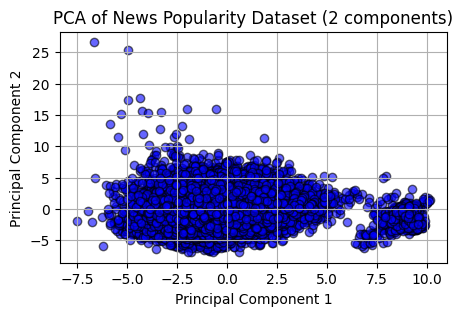

In [120]:
X = news_pop.copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_scaled)

# The explained variance ratio
print(f"Explained variance ratio for 10 components: {pca.explained_variance_ratio_}")

# Plot the results
plt.figure(figsize=(5, 3))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c='blue', edgecolor='k', alpha=0.6)
plt.title("PCA of News Popularity Dataset (2 components)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.show()


After applying PCA, there even still is no clear relatioship observable. 

**Random Forest**

We apply Random Forest to the original data with the PCA transformed features since its the best model observed in the previous analysis.

In [122]:
# Train-test split the data for models using PCA data
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y, test_size=0.2, random_state=42)

param_grid_rf_pca = {
    'n_estimators': [5, 10, 50, 100],  
    'max_depth': [5, 10, 20],
    'max_features': ['sqrt', 'log2']}

grid_rf_pca = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid_rf_pca, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_rf_pca.fit(X_train_pca, y_train_pca)

print("Best Parameters:", grid_rf_pca.best_params_)
print("Best Estimator:", grid_rf_pca.best_estimator_)

print("\n=== Evaluation: Random Forest with PCA Data ===")

print("Best Cross-Validation Accuracy : {:.4f}".format(grid_rf_pca.best_score_))
print("Test Accuracy : {:.4f}".format(grid_rf_pca.score(X_test_pca, y_test_pca)))

y_test_pred_rf_pca = grid_rf_pca.best_estimator_.predict(X_test_pca)

# Generate a classification report
print("\n=== Classification Report ===")
print(classification_report(y_test_pca, y_test_pred_rf_pca))

# Micro-average precision, recall
micro_precision = precision_score(y_test, y_test_pred_rf_pca, average='micro')
micro_recall = recall_score(y_test, y_test_pred_rf_pca, average='micro')

print("Micro-average Precision: {:.4f}".format(micro_precision))
print("Micro-average Recall: {:.4f}".format(micro_recall))

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 100}
Best Estimator: RandomForestClassifier(max_depth=10)

=== Evaluation: Random Forest with PCA Data ===
Best Cross-Validation Accuracy : 0.6459
Test Accuracy : 0.6385

=== Classification Report ===
              precision    recall  f1-score   support

 Not Popular       0.65      0.52      0.58      3774
     Popular       0.63      0.74      0.68      4155

    accuracy                           0.64      7929
   macro avg       0.64      0.63      0.63      7929
weighted avg       0.64      0.64      0.63      7929

Micro-average Precision: 0.6385
Micro-average Recall: 0.6385


* The result is generally worse than the previous random forest model using the original data.
* Therefore, we stopped experimenting PCA

### 2.3.3 Using Data without outlier by OneClassSVM (Outlier Detection) to fit classifiers:

1. LinearSVC
2. Logitic Regression
3. Random Forest with full features
4. Random Forest with data keeping the top 60% important features

**OneClassSVM outliers detection**

In [135]:
outlier_pipeline_SVM = Pipeline([('scaler', StandardScaler()),  
    ('oneclass_svm', OneClassSVM(kernel='rbf', gamma='scale', nu=0.2))])

outlier_pipeline_SVM.fit(x_train)

# Predict inliers and outliers (-1 = outlier, 1 = inlier) for training data
train_outlier_predictions = outlier_pipeline_SVM.predict(x_train)

# Filter out outliers from the training data
X_train_inliers_SVM = x_train[train_outlier_predictions == 1]
y_train_inliers_SVM = y_train[train_outlier_predictions == 1]

print("Result of One-Class SVM:")
print(f"Number of inliers in training data: {len(X_train_inliers_SVM)}")
print(f"Number of outliers removed from training data: {len(x_train) - len(X_train_inliers_SVM)}")

# Predict inliers and outliers (-1 = outlier, 1 = inlier) for test data
test_outlier_predictions_SVM = outlier_pipeline_SVM.predict(x_test)

# Filter out outliers from the test data
X_test_inliers_SVM = x_test[test_outlier_predictions_SVM == 1]
y_test_inliers_SVM = y_test[test_outlier_predictions_SVM == 1]

print(f"Number of inliers in test data: {len(X_test_inliers_SVM)}") 
print(f"Number of outliers removed from test data: {len(x_test) - len(X_test_inliers_SVM)}")

Result of One-Class SVM:
Number of inliers in training data: 25372
Number of outliers removed from training data: 6343
Number of inliers in test data: 6360
Number of outliers removed from test data: 1569


#### 2.3.3.1 LinearSVC

In [125]:
svc_pipeline = Pipeline([("Scaler", "passthrough"), ("Classifier", LinearSVC(dual=False, max_iter=5000))])

param_grid = {
    "Scaler": [StandardScaler(), MinMaxScaler(), 'passthrough'],
    "Classifier__C": np.logspace(-6, 6, num=13) 
}

grid = GridSearchCV(svc_pipeline, param_grid, cv=10, n_jobs=-1)
grid.fit(X_train_inliers_SVM, y_train_inliers_SVM)


print("\nBest Parameters:", grid.best_params_)
print("Best Estimator:", grid.best_estimator_)

# Accuracy
print(f"Training Score (accuracy) of Best Estimator: {grid.best_score_:.4f}")
print(f"Test Score (accuracy) of Best Estimator: {grid.score(X_test_inliers_SVM, y_test_inliers_SVM):.4f}")


print("\n=== Evaluation: LinearSVC without outliers by OneClassSVM===")

best_estimator_SVC = grid.best_estimator_.fit(X_train_inliers_SVM, y_train_inliers_SVM)

# Classification Report
print("Classification report:\n", classification_report(y_test_inliers_SVM, best_estimator_SVC.predict(X_test_inliers_SVM), digits=4))

# Macro-average Precision, Recall & F1-score
micro_precision = precision_score(y_test_inliers_SVM, best_estimator_SVC.predict(X_test_inliers_SVM), average='micro')
micro_recall = recall_score(y_test_inliers_SVM, best_estimator_SVC.predict(X_test_inliers_SVM), average='micro')
print(f"Micro-average Precision: {micro_precision:.4f}")
print(f"Micro-average Recall: {micro_recall:.4f}")


Best Parameters: {'Classifier__C': 0.001, 'Scaler': StandardScaler()}
Best Estimator: Pipeline(steps=[('Scaler', StandardScaler()),
                ('Classifier', LinearSVC(C=0.001, dual=False, max_iter=5000))])
Training Score (accuracy) of Best Estimator: 0.6516
Test Score (accuracy) of Best Estimator: 0.6474

=== Evaluation: LinearSVC without outliers by OneClassSVM===
Classification report:
               precision    recall  f1-score   support

 Not Popular     0.6513    0.6387    0.6449      3208
     Popular     0.6436    0.6561    0.6498      3190

    accuracy                         0.6474      6398
   macro avg     0.6475    0.6474    0.6474      6398
weighted avg     0.6475    0.6474    0.6474      6398

Micro-average Precision: 0.6474
Micro-average Recall: 0.6474


#### 2.3.3.2 Logistic Regression

In [126]:
logreg_pipeline = make_pipeline(StandardScaler(), LogisticRegression(dual=False, solver='saga', max_iter=5000))

logreg_param_grid = {'standardscaler': [StandardScaler(), MinMaxScaler(), 'passthrough'],
                     'logisticregression__C': [0.01, 0.1, 1, 10, 100]}

logreg_grid = GridSearchCV(logreg_pipeline, logreg_param_grid, cv=5, n_jobs=-1)
logreg_grid.fit(X_train_inliers_SVM, y_train_inliers_SVM)

# Best parameters and best estimator
print("\nBest Parameters:", logreg_grid.best_params_)
print("Best Estimator:", logreg_grid.best_estimator_)

# Accuracy on training and test sets
print(f"Training Score (accuracy) of Best Estimator: {logreg_grid.best_score_:.4f}")
print(f"Test Score (accuracy) of Best Estimator: {logreg_grid.score(X_test_inliers_SVM, y_test_inliers_SVM):.4f}")

print("\n=== Evaluation: LogisticRegressor without outliers by OneClassSVM ===")

# Evaluate on cleaned test data
y_pred_logreg_logreg_OCS = logreg_grid.best_estimator_.predict(X_test_inliers_SVM)

# Classification Report on cleaned test data
print("Classification report:\n", classification_report(y_test_inliers_SVM, y_pred_logreg_logreg_OCS, digits= 4))

# Macro-average Precision, Recall & F1-score
micro_precision = precision_score(y_test_inliers_SVM, y_pred_logreg_logreg_OCS, average='micro')
micro_recall = recall_score(y_test_inliers_SVM, y_pred_logreg_logreg_OCS, average='micro')
print(f"Micro-average Precision: {micro_precision:.4f}")
print(f"Micro-average Recall: {micro_recall:.4f}")


Best Parameters: {'logisticregression__C': 0.01, 'standardscaler': StandardScaler()}
Best Estimator: Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=0.01, max_iter=5000, solver='saga'))])
Training Score (accuracy) of Best Estimator: 0.6520
Test Score (accuracy) of Best Estimator: 0.6474

=== Evaluation: LogisticRegressor without outliers by OneClassSVM ===
Classification report:
               precision    recall  f1-score   support

 Not Popular     0.6519    0.6368    0.6443      3208
     Popular     0.6431    0.6580    0.6504      3190

    accuracy                         0.6474      6398
   macro avg     0.6475    0.6474    0.6474      6398
weighted avg     0.6475    0.6474    0.6474      6398

Micro-average Precision: 0.6474
Micro-average Recall: 0.6474


#### 2.3.3.3 Random Forest with full fetures

In [136]:
grid_rf = GridSearchCV(estimator=pipeline_rf, param_grid=param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_rf.fit(X_train_inliers_SVM, y_train_inliers_SVM)

print("\n=== RandomForestClassifier Without Outliers (Cleaned Data) ===")

print("Best Parameters:", grid_rf.best_params_)
print("Best Estimator:", grid_rf.best_estimator_)

# Accuracy
print(f"Best Cross-Validation Score: {grid_rf.best_score_:.4f}")
print(f"Test Accuracy (After Isolation Forest): {grid_rf.score(X_test_inliers_SVM, y_test_inliers_SVM):.4f}")

print("\n=== Evaluation: RandomForestClassifier Without Outliers by OneClassSVM ===")

# Predictions on cleaned test data
y_pred_rf_cleaned = grid_rf.best_estimator_.predict(X_test_inliers_SVM)

print("Classification Report:\n", classification_report(y_test_inliers_SVM, y_pred_rf_cleaned, digits=4))

# Micro-average Precision and Recall
micro_precision_rf = precision_score(y_test_inliers_SVM, y_pred_rf_cleaned, average='micro')
micro_recall_rf = recall_score(y_test_inliers_SVM, y_pred_rf_cleaned, average='micro')
print(f"Micro-average Precision: {micro_precision_rf:.4f}")
print(f"Micro-average Recall: {micro_recall_rf:.4f}")


Fitting 5 folds for each of 24 candidates, totalling 120 fits

=== RandomForestClassifier Without Outliers (Cleaned Data) ===
Best Parameters: {'classifier__max_depth': 10, 'classifier__max_features': 'log2', 'classifier__n_estimators': 100}
Best Estimator: Pipeline(steps=[('scaler', 'passthrough'),
                ('classifier',
                 RandomForestClassifier(max_depth=10, max_features='log2',
                                        random_state=42))])
Best Cross-Validation Score: 0.6684
Test Accuracy (After Isolation Forest): 0.6681

=== Evaluation: RandomForestClassifier Without Outliers by OneClassSVM ===
Classification Report:
               precision    recall  f1-score   support

 Not Popular     0.6845    0.6173    0.6492      3164
     Popular     0.6547    0.7184    0.6851      3196

    accuracy                         0.6681      6360
   macro avg     0.6696    0.6678    0.6671      6360
weighted avg     0.6695    0.6681    0.6672      6360

Micro-average Precision

#### 2.3.3.4 Random Forest with data keeping the top 60% important features

In [129]:
# In 2.3.1.4.2, x_train_selected_40th and x_test_selected_40th have been defined as 
# Apply OneClassSVM outlier detection on the data keeping the top 60% important features

outlier_pipeline_SVM = Pipeline([
    ('scaler', StandardScaler()),  
    ('oneclass_svm', OneClassSVM(kernel='rbf', gamma='scale', nu=0.2)) 
])

outlier_pipeline_SVM.fit(x_train_selected_40th)

# Predict inliers and outliers (-1 = outlier, 1 = inlier) for training data
train_outlier_predictions = outlier_pipeline_SVM.predict(x_train_selected_40th)

# Filter out outliers from the training data
X_train_inliers_SVM = x_train_selected_40th[train_outlier_predictions == 1]
y_train_inliers_SVM = y_train[train_outlier_predictions == 1]

# Predict inliers and outliers (-1 = outlier, 1 = inlier) for test data
test_outlier_predictions_SVM = outlier_pipeline_SVM.predict(x_test_selected_40th)

# Filter out outliers from the test data
X_test_inliers_SVM = x_test_selected_40th[test_outlier_predictions_SVM == 1]
y_test_inliers_SVM = y_test[test_outlier_predictions_SVM == 1]

print("Result of One-Class SVM:")
print(f"Number of inliers in training data: {len(X_train_inliers_SVM)}")
print(f"Number of outliers removed from training data: {len(x_train_selected_40th) - len(X_train_inliers_SVM)}")
print(f"Number of inliers in test data: {len(X_test_inliers_SVM)}")
print(f"Number of outliers removed from test data: {len(x_test_selected_40th) - len(X_test_inliers_SVM)}")


Result of One-Class SVM:
Number of inliers in training data: 25371
Number of outliers removed from training data: 6344
Number of inliers in test data: 6398
Number of outliers removed from test data: 1531


In [133]:
pipeline_rf_cleaned = Pipeline([('classifier', RandomForestClassifier(random_state=42))])

param_grid_rf_cleaned = {
    'classifier__n_estimators': [5, 10, 50, 100],  
    'classifier__max_depth': [5, 10, 20],
    'classifier__max_features': ['sqrt', 'log2']
}

grid_rf_cleaned = GridSearchCV(
    estimator=pipeline_rf_cleaned, 
    param_grid=param_grid_rf_cleaned, 
    cv=5, 
    scoring='accuracy', 
    n_jobs=-1, 
    verbose=1
)

grid_rf_cleaned.fit(X_train_inliers_SVM, y_train_inliers_SVM)

print("\n=== Evaluation: RandomForestClassifier top 60 percent features Without Outliers by OneClassSVM ===")

print("Best Parameters:", grid_rf_cleaned.best_params_)
print("Best Estimator:", grid_rf_cleaned.best_estimator_)

# Accuracy
print("Best Cross-Validation Score: {:.4f}".format(grid_rf_cleaned.best_score_))
print(f"Test Accuracy (After One-Class SVM): {grid_rf_cleaned.score(X_test_inliers_SVM, y_test_inliers_SVM):.4f}")

# Predictions on cleaned test data
y_pred_rf_cleaned = grid_rf_cleaned.best_estimator_.predict(X_test_inliers_SVM)

print("Classification Report:\n", classification_report(y_test_inliers_SVM, y_pred_rf_cleaned, digits=4))

# Micro-average precision and recall
micro_precision_rf_cleaned = precision_score(y_test_inliers_SVM, y_pred_rf_cleaned, average='micro')
micro_recall_rf_cleaned = recall_score(y_test_inliers_SVM, y_pred_rf_cleaned, average='micro')
print(f"Micro-average Precision: {micro_precision_rf_cleaned:.4f}")
print(f"Micro-average Recall: {micro_recall_rf_cleaned:.4f}")

Fitting 5 folds for each of 24 candidates, totalling 120 fits



=== Evaluation: RandomForestClassifier top 60 percent features Without Outliers by OneClassSVM ===
Best Parameters: {'classifier__max_depth': 10, 'classifier__max_features': 'sqrt', 'classifier__n_estimators': 100}
Best Estimator: Pipeline(steps=[('classifier',
                 RandomForestClassifier(max_depth=10, random_state=42))])
Best Cross-Validation Score: 0.6652
Test Accuracy (After One-Class SVM): 0.6626
Classification Report:
               precision    recall  f1-score   support

 Not Popular     0.6783    0.6219    0.6489      3208
     Popular     0.6491    0.7034    0.6752      3190

    accuracy                         0.6626      6398
   macro avg     0.6637    0.6627    0.6620      6398
weighted avg     0.6638    0.6626    0.6620      6398

Micro-average Precision: 0.6626
Micro-average Recall: 0.6626


### 2.3.4 Using Data without outlier by Isolation Forest (Outlier Detection) to fit classifiers:
1. LinearSVC
2. Logitic Regression
3. Random Forest with full features
4. Random Forest with data keeping the top 60% important features

**Isolation Forest outlier detection**

In [164]:
iso_forest = IsolationForest(contamination= 0.2, random_state=42)

# Train data: -1 for outliers, 1 for inliers
outlier_flags_train = iso_forest.fit_predict(x_train)  

# Remove outliers from the training data
inlier_indices_train = np.where(outlier_flags_train == 1)[0]
X_train_cleaned = x_train.iloc[inlier_indices_train]
y_train_cleaned = y_train.iloc[inlier_indices_train]

print("Result of Isolation Forest (Outlier Detection):")
print(f"Number of inliers in training data: {len(X_train_cleaned)}")
print(f"Number of outliers removed from training data: {len(x_train) - len(X_train_cleaned)}")

# Detect and remove outliers from the test data
outlier_flags_test = iso_forest.predict(x_test)  # Test data: -1 for outliers, 1 for inliers
inlier_indices_test = np.where(outlier_flags_test == 1)[0]
X_test_cleaned = x_test.iloc[inlier_indices_test]
y_test_cleaned = y_test.iloc[inlier_indices_test]


print(f"Training Data: {len(X_train_cleaned)} inliers, {len(x_train) - len(X_train_cleaned)} outliers removed.")
print(f"Test Data: {len(X_test_cleaned)} inliers, {len(x_test) - len(X_test_cleaned)} outliers removed.")

Result of Isolation Forest (Outlier Detection):
Number of inliers in training data: 25372
Number of outliers removed from training data: 6343
Training Data: 25372 inliers, 6343 outliers removed.
Test Data: 6316 inliers, 1613 outliers removed.


#### 2.3.4.1 Linear SVC Using Data without outlier by Isolation Forest

In [138]:
svc_pipeline = make_pipeline(StandardScaler(), LinearSVC(dual=False, max_iter=5000))
svc_param_grid = {'standardscaler': [StandardScaler(), MinMaxScaler(), 'passthrough'],
                  'linearsvc__C': [0.01, 0.1, 1, 10, 100]}
svc_grid = GridSearchCV(svc_pipeline, svc_param_grid, cv=5, n_jobs=-1)
svc_grid.fit(X_train_cleaned, y_train_cleaned)

print("\nBest Parameters:", svc_grid.best_params_)
print("Best Estimator:", svc_grid.best_estimator_)

print("\n=== Evaluation: LinearSVC without outliers by Isolation Forest ===")

# Accuracy Scores
print("Best Cross-Validation Score: {:.4f}".format(svc_grid.best_score_))
print(f"Test Accuracy (After Isolation Forest): {svc_grid.score(X_test_cleaned, y_test_cleaned):.4f}")

y_pred_lsvc_IF = svc_grid.best_estimator_.predict(X_test_cleaned)

print("Classification Report:\n", classification_report(y_test_cleaned, y_pred_lsvc_IF, digits= 4 ))

# Micro-average Precision and Recall
micro_precision_rf = precision_score(y_test_cleaned, y_pred_lsvc_IF , average='micro')
micro_recall_rf = recall_score(y_test_cleaned, y_pred_lsvc_IF , average='micro')
print(f"Micro-average Precision: {micro_precision_rf:.4f}")
print(f"Micro-average Recall: {micro_recall_rf:.4f}")


Best Parameters: {'linearsvc__C': 1, 'standardscaler': MinMaxScaler()}
Best Estimator: Pipeline(steps=[('standardscaler', MinMaxScaler()),
                ('linearsvc', LinearSVC(C=1, dual=False, max_iter=5000))])

=== Evaluation: LinearSVC without outliers by Isolation Forest ===
Best Cross-Validation Score: 0.6536
Test Accuracy (After Isolation Forest): 0.6533
Classification Report:
               precision    recall  f1-score   support

 Not Popular     0.6553    0.6440    0.6496      3152
     Popular     0.6513    0.6625    0.6568      3164

    accuracy                         0.6533      6316
   macro avg     0.6533    0.6532    0.6532      6316
weighted avg     0.6533    0.6533    0.6532      6316

Micro-average Precision: 0.6533
Micro-average Recall: 0.6533


#### 2.3.4.2 LogisticRegressor Using Data without outlier by Isolation Forest

In [140]:
logreg_pipeline = make_pipeline(StandardScaler(), LogisticRegression(dual=False, solver='saga', max_iter=5000))
logreg_param_grid = {'standardscaler': [StandardScaler(), MinMaxScaler(), 'passthrough'],
                     'logisticregression__C': [0.01, 0.1, 1, 10, 100]}
logreg_grid = GridSearchCV(logreg_pipeline, logreg_param_grid, cv=5, n_jobs=-1)
logreg_grid.fit(X_train_cleaned, y_train_cleaned)

print("Best Parameters:", logreg_grid.best_params_)
print("Best Estimator:", logreg_grid.best_estimator_)

print("\n=== Evaluation: Logistic Regression without outliers by Isolation Forest ===")

# Accuracy Scores
print("Best Cross-Validation Score: {:.4f}".format(logreg_grid.best_score_))
print(f"Test Accuracy (After Isolation Forest): {logreg_grid .score(X_test_cleaned, y_test_cleaned):.4f}")

y_pred_logreg_cleaned = logreg_grid.best_estimator_.predict(X_test_cleaned)

print("Classification Report:\n", classification_report(y_test_cleaned, y_pred_logreg_cleaned, digits= 4))

# Micro-average Precision and Recall
micro_precision_rf = precision_score(y_test_cleaned, y_pred_logreg_cleaned , average='micro')
micro_recall_rf = recall_score(y_test_cleaned, y_pred_logreg_cleaned , average='micro')
print(f"Micro-average Precision: {micro_precision_rf:.4f}")
print(f"Micro-average Recall: {micro_recall_rf:.4f}")

Best Parameters: {'logisticregression__C': 0.01, 'standardscaler': StandardScaler()}
Best Estimator: Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=0.01, max_iter=5000, solver='saga'))])

=== Evaluation: Logistic Regression without outliers by Isolation Forest ===
Best Cross-Validation Score: 0.6541
Test Accuracy (After Isolation Forest): 0.6520
Classification Report:
               precision    recall  f1-score   support

 Not Popular     0.6545    0.6412    0.6478      3152
     Popular     0.6496    0.6628    0.6561      3164

    accuracy                         0.6520      6316
   macro avg     0.6520    0.6520    0.6519      6316
weighted avg     0.6520    0.6520    0.6520      6316

Micro-average Precision: 0.6520
Micro-average Recall: 0.6520


#### 2.3.4.3 Random Forest Using Data with Full Features without outlier by Isolation Forest

In [141]:
grid_org_IF = GridSearchCV(estimator=pipeline_rf, param_grid=param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_org_IF.fit(X_train_cleaned, y_train_cleaned)

print("Best Parameters:", grid_org_IF.best_params_)
print("Best Estimator:", grid_org_IF.best_estimator_)

print("\n=== RandomForestClassifier Full Features Without Outliers (Cleaned Data) ===")

# Accuracy Scores
print(f"Best Cross-Validation Accuracy: {grid_org_IF.best_score_:.4f}")
print(f"Test Accuracy (After Isolation Forest): {grid_org_IF.score(X_test_cleaned, y_test_cleaned):.4f}")

# Predictions on Cleaned Test Data
y_test_pred_rf_IF = grid_org_IF.best_estimator_.predict(X_test_cleaned)

print("Classification Report:\n", classification_report(y_test_cleaned, y_test_pred_rf_IF, digits= 4))

# Micro-average Precision and Recall
micro_precision_clean = precision_score(y_test_cleaned, y_test_pred_rf_IF, average='micro')
micro_recall_clean = recall_score(y_test_cleaned, y_test_pred_rf_IF, average='micro')
print(f"Micro-average Precision (Cleaned Test Data): {micro_precision_clean:.4f}")
print(f"Micro-average Recall (Cleaned Test Data): {micro_recall_clean:.4f}")


Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Parameters: {'classifier__max_depth': 10, 'classifier__max_features': 'log2', 'classifier__n_estimators': 100}
Best Estimator: Pipeline(steps=[('scaler', 'passthrough'),
                ('classifier',
                 RandomForestClassifier(max_depth=10, max_features='log2',
                                        random_state=42))])

=== RandomForestClassifier Full Features Without Outliers (Cleaned Data) ===
Best Cross-Validation Accuracy: 0.6649
Test Accuracy (After Isolation Forest): 0.6650
Classification Report:
               precision    recall  f1-score   support

 Not Popular     0.6772    0.6282    0.6517      3152
     Popular     0.6545    0.7016    0.6772      3164

    accuracy                         0.6650      6316
   macro avg     0.6658    0.6649    0.6645      6316
weighted avg     0.6658    0.6650    0.6645      6316

Micro-average Precision (Cleaned Test Data): 0.6650
Micro-average Recall (Cleaned 

#### 2.3.4.4 Random Forest Using Data with top 60% important Features without outlier by Isolation Forest

In [142]:
# Apply Isolation Forest for outlier detection on the data keeping top 60% important features
iso_forest_40th = IsolationForest(contamination=0.2, random_state=42)
outlier_flags_train_40th = iso_forest_40th.fit_predict(x_train_selected_40th) 

# Remove outliers from the training data
inlier_indices_train_40th = np.where(outlier_flags_train_40th == 1)[0]
X_train_cleaned_40th = x_train_selected_40th.iloc[inlier_indices_train_40th]
y_train_cleaned_40th = y_train.iloc[inlier_indices_train_40th]

# Remove outliers from the test data
outlier_flags_test_40th = iso_forest_40th.predict(x_test_selected_40th)
inlier_indices_test_40th = np.where(outlier_flags_test_40th == 1)[0]
X_test_cleaned_40th = x_test_selected_40th.iloc[inlier_indices_test_40th]
y_test_cleaned_40th = y_test.iloc[inlier_indices_test_40th]

print("Result of Isolation Forest (40th Percentile Features):")
print(f"Training Data: {len(X_train_cleaned_40th)} inliers, {len(x_train_selected_40th) - len(X_train_cleaned_40th)} outliers removed.")
print(f"Test Data: {len(X_test_cleaned_40th)} inliers, {len(x_test_selected_40th) - len(X_test_cleaned_40th)} outliers removed.")


Result of Isolation Forest (40th Percentile Features):
Training Data: 25372 inliers, 6343 outliers removed.
Test Data: 6335 inliers, 1594 outliers removed.


In [143]:
pipeline_rf_IF_40th = Pipeline([('classifier', RandomForestClassifier(random_state=42))])

grid_rf_IF_40th = GridSearchCV(
    estimator=pipeline_rf_IF_40th, 
    param_grid=param_grid_rf_cleaned, 
    cv=5, 
    scoring='accuracy', 
    n_jobs=-1, 
    verbose=1)

grid_rf_IF_40th.fit(X_train_cleaned_40th, y_train_cleaned_40th)

print("\n=== RandomForestClassifier Without Outliers (Cleaned Data, top 60 percent important Features) ===")

print("Best Parameters:", grid_rf_IF_40th.best_params_)
print("Best Estimator:", grid_rf_IF_40th.best_estimator_)
print("Best Cross-Validation Accuracy: {:.4f}".format(grid_rf_IF_40th.best_score_))
print(f"Test Accuracy (After Isolation Forest): {grid_rf_IF_40th.score(X_test_cleaned_40th, y_test_cleaned_40th):.4f}")

y_test_pred_rf_IF_40th = grid_rf_IF_40th.best_estimator_.predict(X_test_cleaned_40th)

# Classification Report
print("Classification Report:\n", classification_report(y_test_cleaned_40th, y_test_pred_rf_IF_40th, digits=4))

# Micro-average precision and recall
micro_precision_IF_40th = precision_score(y_test_cleaned_40th, y_test_pred_rf_IF_40th, average='micro')
micro_recall_IF_40th = recall_score(y_test_cleaned_40th, y_test_pred_rf_IF_40th, average='micro')
print(f"Micro-average Precision (Cleaned Test Data): {micro_precision_IF_40th:.4f}")
print(f"Micro-average Recall (Cleaned Test Data): {micro_recall_IF_40th:.4f}")


Fitting 5 folds for each of 24 candidates, totalling 120 fits

=== RandomForestClassifier Without Outliers (Cleaned Data, top 60 percent important Features) ===
Best Parameters: {'classifier__max_depth': 10, 'classifier__max_features': 'sqrt', 'classifier__n_estimators': 50}
Best Estimator: Pipeline(steps=[('classifier',
                 RandomForestClassifier(max_depth=10, n_estimators=50,
                                        random_state=42))])
Best Cross-Validation Accuracy: 0.6571
Test Accuracy (After Isolation Forest): 0.6565
Classification Report:
               precision    recall  f1-score   support

 Not Popular     0.6707    0.6391    0.6545      3225
     Popular     0.6432    0.6746    0.6585      3110

    accuracy                         0.6565      6335
   macro avg     0.6569    0.6568    0.6565      6335
weighted avg     0.6572    0.6565    0.6565      6335

Micro-average Precision (Cleaned Test Data): 0.6565
Micro-average Recall (Cleaned Test Data): 0.6565


### 2.3.5. Dive Into The Best Model: Random Forest Classifier With Full Features & Without Outliers by Isolation Forest

We find random forest classifier without outliers by Isolation Forest performed better gernerally. Therefore, we will dive deeper into the exploration of the model. 

**1. Balance the two classes by class_weight**

In [166]:
pipeline_rf_balance = Pipeline([
    ('scaler', 'passthrough'),
    ('classifier', RandomForestClassifier(class_weight= "balanced",random_state=42))])

grid_org_IF_balance = GridSearchCV(estimator=pipeline_rf_balance, param_grid=param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_org_IF_balance.fit(X_train_cleaned, y_train_cleaned)

print("\n=== Evaluation: RandomForestClassifier Without Outliers by Isolation Forest After Balance===")

# Accuracy Scores
print("Best Parameters:", grid_org_IF_balance.best_params_)
print("Best Estimator:", grid_org_IF_balance.best_estimator_)

print(f"Best Cross-Validation Accuracy:: {grid_org_IF_balance.best_score_:.4f}")
print(f"Test Accuracy (After Isolation Forest): {grid_org_IF_balance.score(X_test_cleaned, y_test_cleaned):.4f}")

# Predictions on Cleaned Test Data
y_test_pred_rf_IF_bal = grid_org_IF_balance.best_estimator_.predict(X_test_cleaned)

print("Classification Report:\n", classification_report(y_test_cleaned, y_test_pred_rf_IF_bal, digits=4))

# Micro-average Precision and Recall
micro_precision_clean = precision_score(y_test_cleaned, y_test_pred_rf_IF_bal, average='micro')
micro_recall_clean = recall_score(y_test_cleaned, y_test_pred_rf_IF_bal, average='micro')
print(f"Micro-average Precision (Cleaned Test Data): {micro_precision_clean:.4f}")
print(f"Micro-average Recall (Cleaned Test Data): {micro_recall_clean:.4f}")


Fitting 5 folds for each of 24 candidates, totalling 120 fits

=== Evaluation: RandomForestClassifier Without Outliers by Isolation Forest After Balance===
Best Parameters: {'classifier__max_depth': 10, 'classifier__max_features': 'log2', 'classifier__n_estimators': 100}
Best Estimator: Pipeline(steps=[('scaler', 'passthrough'),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced', max_depth=10,
                                        max_features='log2',
                                        random_state=42))])
Best Cross-Validation Accuracy:: 0.6646
Test Accuracy (After Isolation Forest): 0.6713
Classification Report:
               precision    recall  f1-score   support

 Not Popular     0.6755    0.6570    0.6661      3152
     Popular     0.6674    0.6855    0.6763      3164

    accuracy                         0.6713      6316
   macro avg     0.6714    0.6713    0.6712      6316
weighted avg     0.6714    0.6713    0.6712      6316



**2. Balanced Random Forest Classifier Without Outliers by Isolation Forest Keeping the Top 50% important features**

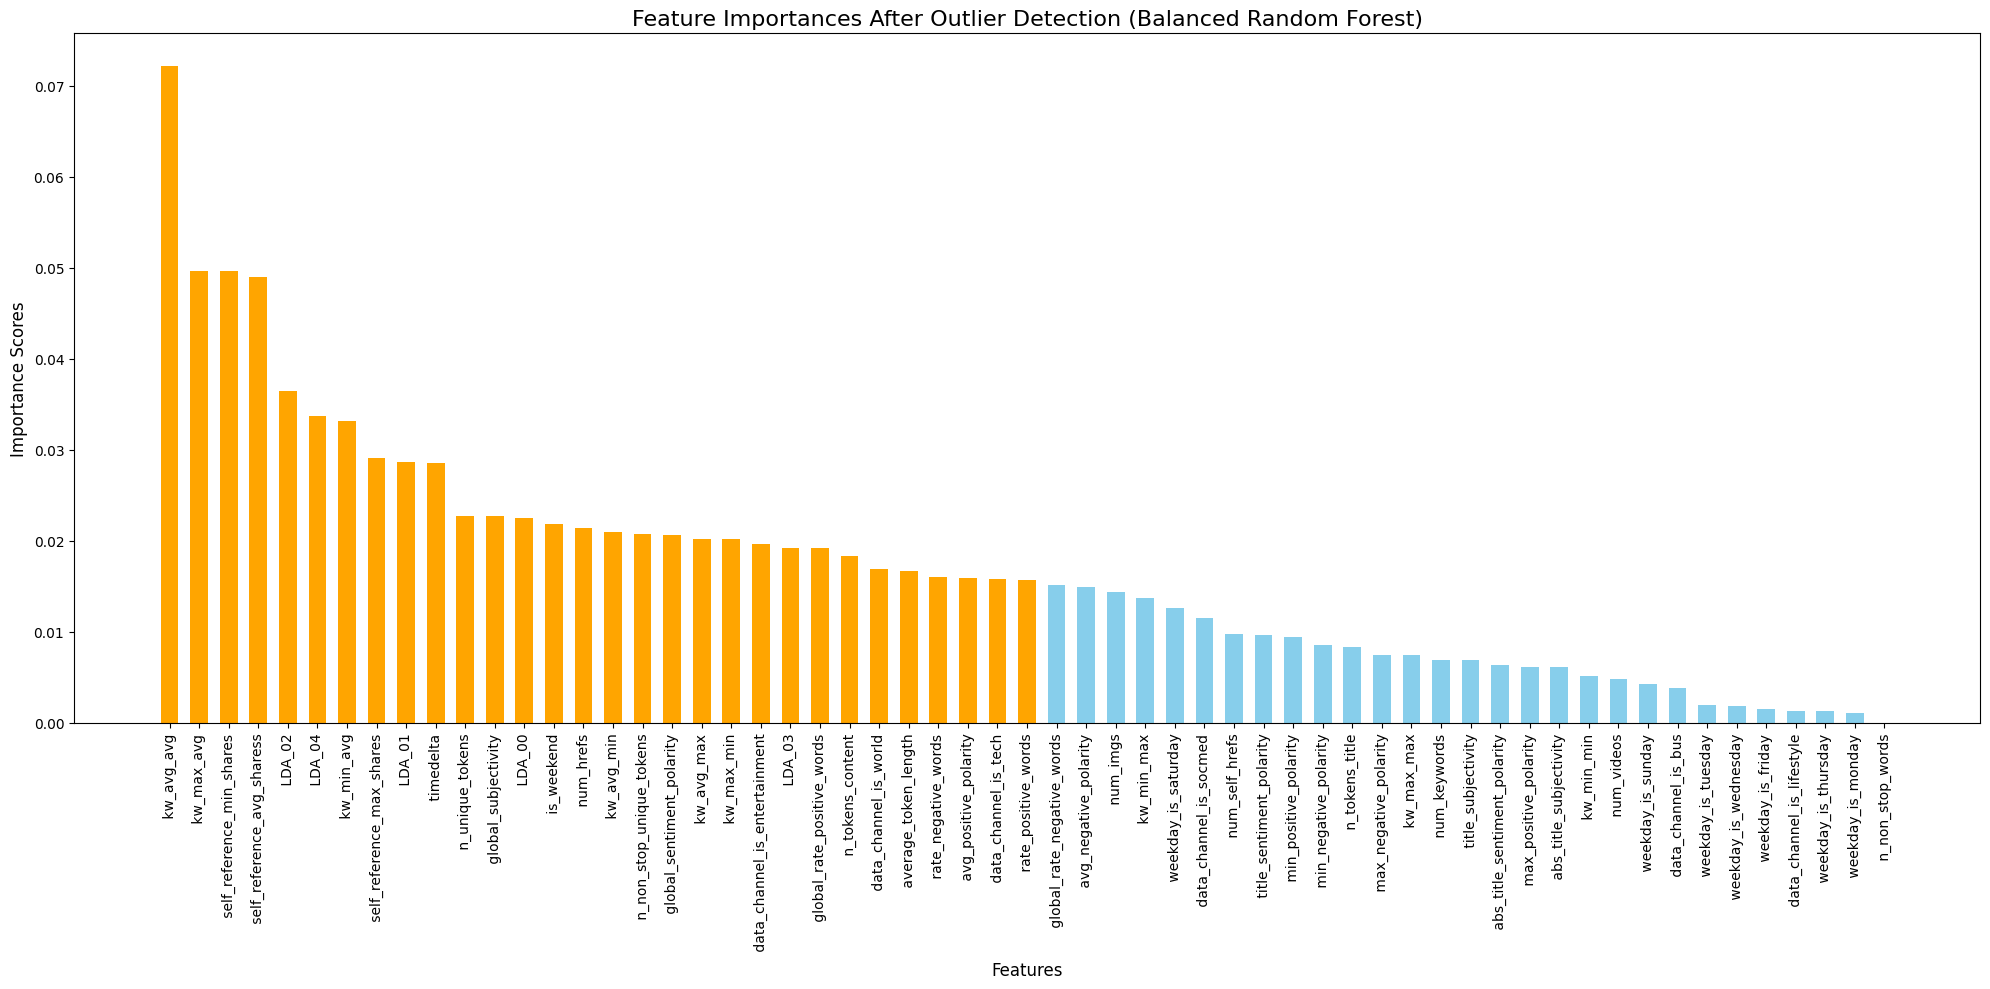

In [ ]:
rf_balanced = grid_org_IF_balance.best_estimator_.named_steps['classifier']
feature_importances_rf_balanced = rf_balanced.feature_importances_

all_features_balanced = X_train_cleaned.columns

selector_rf_balanced = SelectFromModel(estimator=rf_balanced, threshold="median", prefit=True)

selected_features_mask_balanced = selector_rf_balanced.get_support()

feature_comparison_df_balanced = pd.DataFrame({
    'Feature': all_features_balanced,
    'Importance': feature_importances_rf_balanced,
    'Selected': selected_features_mask_balanced
})

# Sort features by importance
feature_comparison_df_balanced = feature_comparison_df_balanced.sort_values(by='Importance', ascending=False)

# Plot feature importance with selected features highlighted
plt.figure(figsize=(20, 10))
x_positions = np.arange(len(feature_comparison_df_balanced))  # Position for each feature

# Plot feature importance bars
plt.bar(
    x_positions, 
    feature_comparison_df_balanced['Importance'], 
    color=np.where(feature_comparison_df_balanced['Selected'], 'orange', 'skyblue'), 
    width=0.6, 
    label='Feature Importance'
)

plt.xticks(x_positions, feature_comparison_df_balanced['Feature'], rotation=90, fontsize=10)
plt.ylabel("Importance Scores", fontsize=12)
plt.xlabel("Features", fontsize=12)
plt.title("Feature Importances After Outlier Detection (Balanced Random Forest)", fontsize=16)
plt.tight_layout()
plt.show()


In [ ]:
plt.figure(figsize=(20, 10))
x_positions_40th = np.arange(len(selected_features_rf_balanced_40th))  # Positions for selected features

importance_values_40th = feature_importances_rf_balanced[selected_features_mask_balanced_40th]

plt.bar(
    x_positions_40th, 
    importance_values_40th, 
    color='orange', 
    width=0.6, 
    label='Feature Importance'
)

plt.xticks(x_positions_40th, selected_features_rf_balanced_40th, rotation=90, fontsize=10)
plt.ylabel("Importance Scores", fontsize=12)
plt.xlabel("Features", fontsize=12)
plt.title("Feature Importances (40th Percentile Threshold - Balanced Random Forest)", fontsize=16)
plt.tight_layout()
plt.show()


In [ ]:
selected_features_rf_balanced_50th = feature_comparison_df_balanced[feature_comparison_df_balanced['Selected']]['Feature'].values

X_train_selected_balanced = X_train_cleaned[selected_features_rf_balanced_50th]
X_test_selected_balanced = X_test_cleaned[selected_features_rf_balanced_50th]

pipeline_rf_balanced_selected = Pipeline([
    ('classifier', RandomForestClassifier(random_state=42))
])

param_grid_rf_balanced_selected = {
    'classifier__n_estimators': [5, 10, 50, 100],  
    'classifier__max_depth': [5, 10, 20],
    'classifier__max_features': ['sqrt', 'log2']
}

grid_balanced_selected = GridSearchCV(
    estimator=pipeline_rf_balanced_selected, 
    param_grid=param_grid_rf_balanced_selected, 
    cv=5, 
    scoring='accuracy', 
    n_jobs=-1, 
    verbose=1
)

grid_balanced_selected.fit(X_train_selected_balanced, y_train_cleaned)

best_params_selected = grid_balanced_selected.best_params_
best_cv_score_selected = grid_balanced_selected.best_score_
test_score_selected_balanced = grid_balanced_selected.score(X_test_selected_balanced, y_test_cleaned)

y_test_pred_rf_balanced_selected = grid_balanced_selected.best_estimator_.predict(X_test_selected_balanced)

micro_precision_balanced_selected = precision_score(y_test_cleaned, y_test_pred_rf_balanced_selected, average='micro')
micro_recall_balanced_selected = recall_score(y_test_cleaned, y_test_pred_rf_balanced_selected, average='micro')

# Print results
print("Best Parameters:", best_params_selected)
print("Best Estimator:", grid_balanced_selected.best_estimator_)

print("Best Cross-Validation Accuracy: {:.4f}".format(best_cv_score_selected))
print("Test Accuracy: {:.4f}".format(test_score_selected_balanced))

# Classification Report
print("\n=== Classification Report ===")
print(classification_report(y_test_cleaned, y_test_pred_rf_balanced_selected, digits=4))

# Micro-average precision and recall
print("Micro-average Precision: {:.4f}".format(micro_precision_balanced_selected))
print("Micro-average Recall: {:.4f}".format(micro_recall_balanced_selected))


Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Parameters: {'classifier__max_depth': 10, 'classifier__max_features': 'sqrt', 'classifier__n_estimators': 50}
Best Estimator: Pipeline(steps=[('classifier',
                 RandomForestClassifier(max_depth=10, n_estimators=50,
                                        random_state=42))])
Best Cross-Validation Accuracy: 0.6631
Test Accuracy: 0.6664

=== Classification Report ===
              precision    recall  f1-score   support

 Not Popular     0.6796    0.6272    0.6524      3152
     Popular     0.6551    0.7054    0.6793      3164

    accuracy                         0.6664      6316
   macro avg     0.6674    0.6663    0.6659      6316
weighted avg     0.6673    0.6664    0.6659      6316

Micro-average Precision: 0.6664
Micro-average Recall: 0.6664


**3. Balanced Random Forest Classifier Without Outliers by Isolation Forest Keeping the Top 60% important features**

This is worse than above so that we decided not to conduct further feature selection.

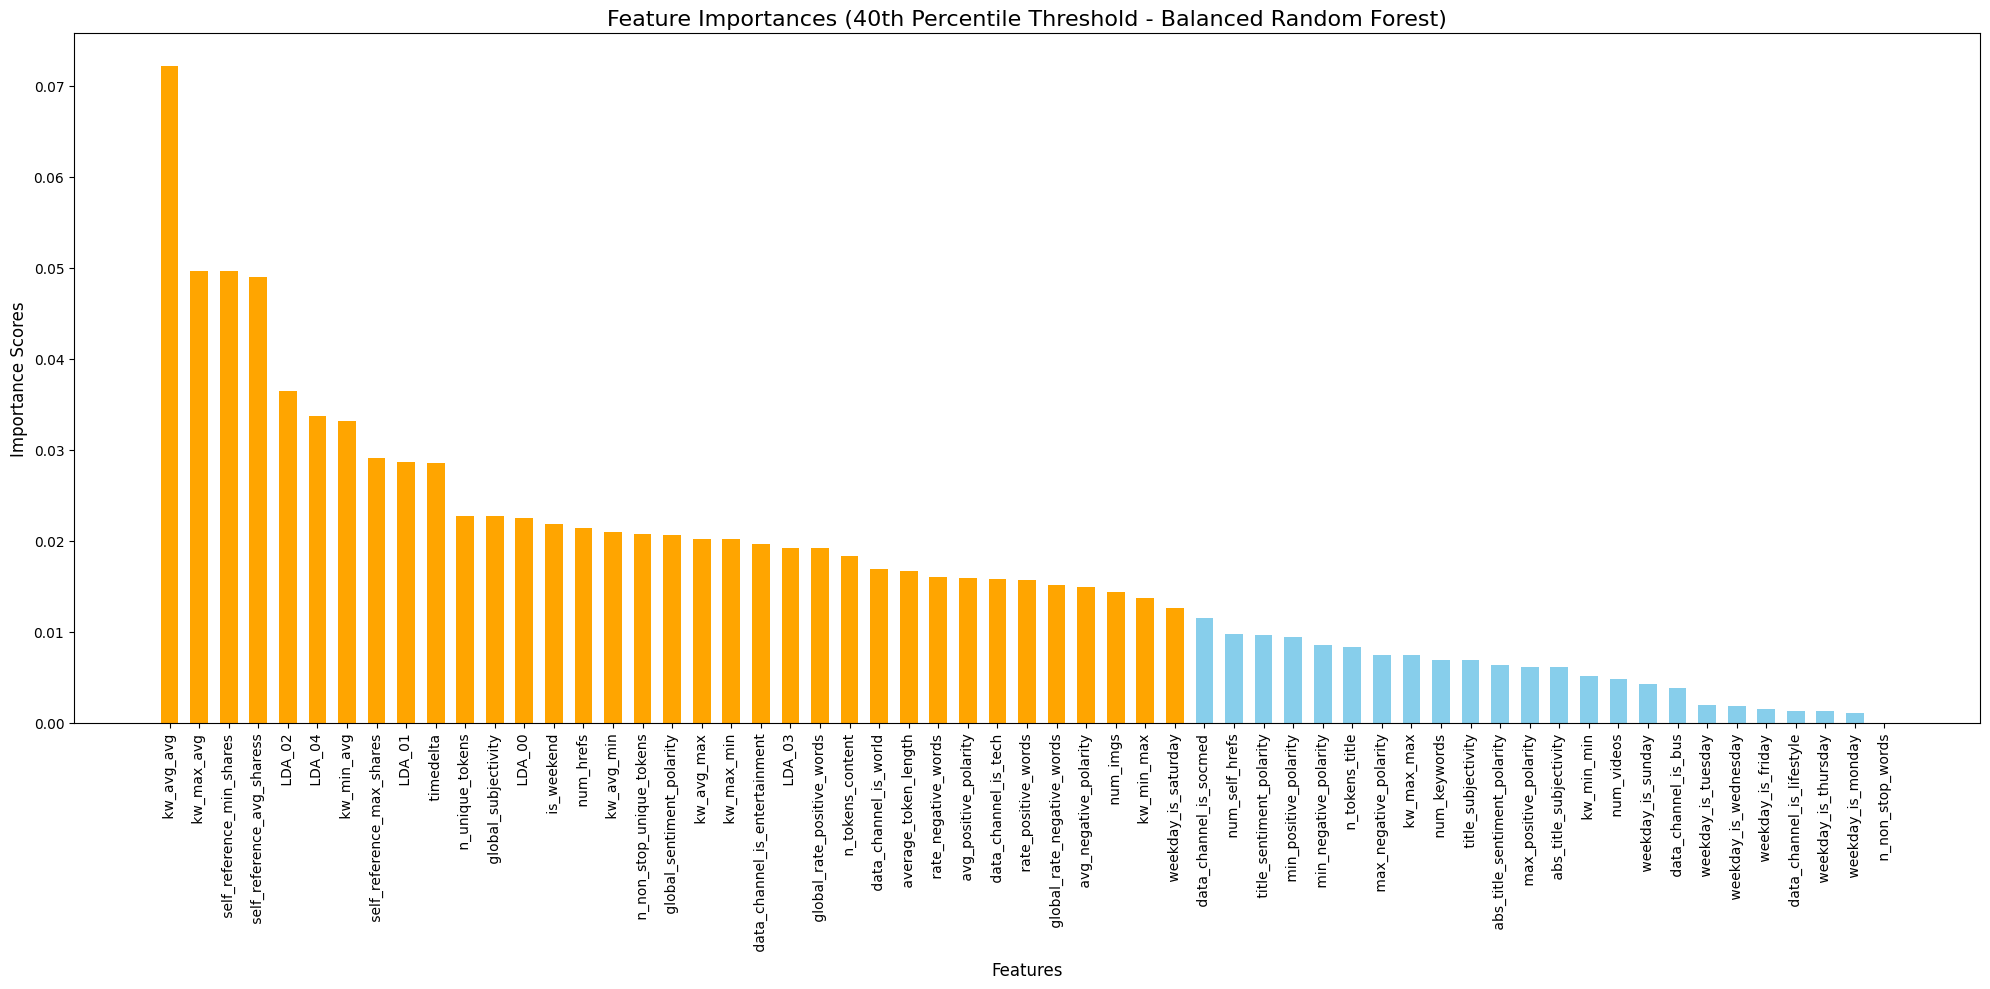

In [ ]:
threshold_40th = np.percentile(feature_importances_rf_balanced, 40)

selector_rf_balanced_40th = SelectFromModel(estimator=rf_balanced, threshold=threshold_40th, prefit=True)

selected_features_mask_balanced_40th = selector_rf_balanced_40th.get_support()

selected_features_rf_balanced_40th = X_train_cleaned.columns[selected_features_mask_balanced_40th]

X_train_selected_balanced_40th = X_train_cleaned[selected_features_rf_balanced_40th]
X_test_selected_balanced_40th = X_test_cleaned[selected_features_rf_balanced_40th]

plt.figure(figsize=(20, 10))
x_positions_40th = np.arange(len(feature_comparison_df_balanced))  # Positions for all features

selected_mask_40th = feature_comparison_df_balanced['Feature'].isin(selected_features_rf_balanced_40th)

plt.bar(
    x_positions_40th, 
    feature_comparison_df_balanced['Importance'], 
    color=np.where(selected_mask_40th, 'orange', 'skyblue'), 
    width=0.6, 
    label='Feature Importance'
)

plt.xticks(x_positions_40th, feature_comparison_df_balanced['Feature'], rotation=90, fontsize=10)
plt.ylabel("Importance Scores", fontsize=12)
plt.xlabel("Features", fontsize=12)
plt.title("Feature Importances (40th Percentile Threshold - Balanced Random Forest)", fontsize=16)
plt.tight_layout()
plt.show()

In [175]:
pipeline_rf_balanced_selected_40th = Pipeline([
    ('classifier', RandomForestClassifier(random_state=42))
])

param_grid_rf_balanced_selected_40th = {
    'classifier__n_estimators': [5, 10, 50, 100],  
    'classifier__max_depth': [5, 10, 20],
    'classifier__max_features': ['sqrt', 'log2']
}

grid_balanced_selected_40th = GridSearchCV(
    estimator=pipeline_rf_balanced_selected_40th, 
    param_grid=param_grid_rf_balanced_selected_40th, 
    cv=5, 
    scoring='accuracy', 
    n_jobs=-1, 
    verbose=1)

grid_balanced_selected_40th.fit(X_train_selected_balanced_40th, y_train_cleaned)

# Best parameters and scores
best_params_selected_40th = grid_balanced_selected_40th.best_params_
best_cv_score_selected_40th = grid_balanced_selected_40th.best_score_
test_score_selected_balanced_40th = grid_balanced_selected_40th.score(X_test_selected_balanced_40th, y_test_cleaned)

# Predictions on the test set
y_test_pred_rf_balanced_selected_40th = grid_balanced_selected_40th.best_estimator_.predict(X_test_selected_balanced_40th)

# Compute Micro-average precision and recall
micro_precision_balanced_selected_40th = precision_score(y_test_cleaned, y_test_pred_rf_balanced_selected_40th, average='micro')
micro_recall_balanced_selected_40th = recall_score(y_test_cleaned, y_test_pred_rf_balanced_selected_40th, average='micro')

# Print results
print("Best Parameters:", best_params_selected_40th)
print("Best Estimator:", grid_balanced_selected_40th.best_estimator_)

print("Best Cross-Validation Accuracy: {:.4f}".format(best_cv_score_selected_40th))
print("Test Accuracy: {:.4f}".format(test_score_selected_balanced_40th))

# Classification Report
print("\n=== Classification Report (40th Percentile Features) ===")
print(classification_report(y_test_cleaned, y_test_pred_rf_balanced_selected_40th, digits=4))

# Micro-average precision and recall
print("Micro-average Precision: {:.4f}".format(micro_precision_balanced_selected_40th))
print("Micro-average Recall: {:.4f}".format(micro_recall_balanced_selected_40th))


Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Parameters: {'classifier__max_depth': 10, 'classifier__max_features': 'sqrt', 'classifier__n_estimators': 100}
Best Estimator: Pipeline(steps=[('classifier',
                 RandomForestClassifier(max_depth=10, random_state=42))])
Best Cross-Validation Accuracy: 0.6625
Test Accuracy: 0.6648

=== Classification Report (40th Percentile Features) ===
              precision    recall  f1-score   support

 Not Popular     0.6774    0.6269    0.6512      3152
     Popular     0.6540    0.7026    0.6774      3164

    accuracy                         0.6648      6316
   macro avg     0.6657    0.6647    0.6643      6316
weighted avg     0.6657    0.6648    0.6643      6316

Micro-average Precision: 0.6648
Micro-average Recall: 0.6648


## MISSION 2
#### Clustering articles on the types of words, topics, and general sentiment (provided as features) and examining if these clusters correspond with article popularity.

In [ ]:
# Select all rows for the adjusted columns (columns 1-51)
features = news_pop.iloc[:, [1, 2, 3, 4, 5, 10, 11, 12, 13, 14, 15, 16, 17, 
                                      18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 38, 
                                      39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 
                                      50, 51]]

news_pop['pop_label'] = news_pop[' shares'].apply(lambda x: 1 if x > 1400 else 0)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


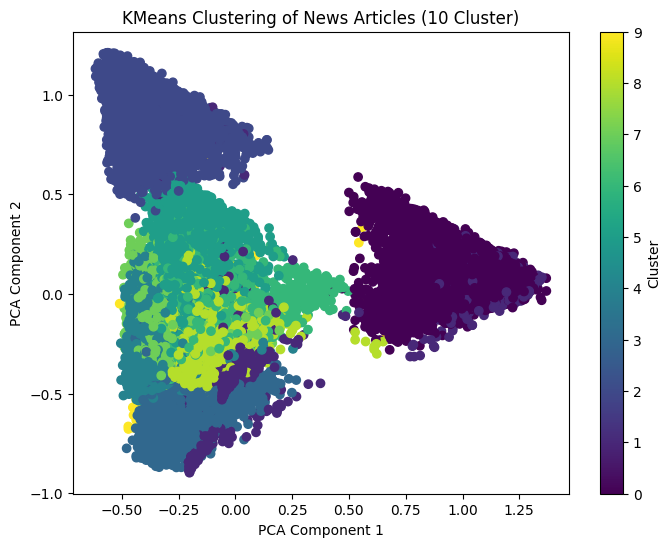

In [ ]:
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

# KMeans clustering
kmeans = KMeans(n_clusters=10, random_state=42)
news_pop['cluster'] = kmeans.fit_predict(features_scaled)

pca = PCA(n_components=2)
reduced_data = pca.fit_transform(features_scaled)

# Visualize 2D
plt.figure(figsize=(8, 6))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=news_pop['cluster'], cmap='viridis')
plt.title('KMeans Clustering of News Articles (10 Cluster)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

In [ ]:
# Compare clusters with popularity
cluster_popularity_comparison = news_pop.groupby('cluster')['pop_label'].mean()

print("Comparison of Clusters with Popularity:")
print(cluster_popularity_comparison)

Comparison of Clusters with Popularity:
cluster
0    0.342917
1    0.548003
2    0.592901
3    0.370463
4    0.509904
5    0.568116
6    0.716989
7    0.460864
8    0.617034
9    0.497704
Name: pop_label, dtype: float64


In [ ]:
# Calculate the counts of 'pop_label' in each cluster
cluster_popularity_counts = news_pop.groupby('cluster')['pop_label'].value_counts()

print("Cluster Purity (Distribution of Popularity within Each Cluster):")
print(cluster_popularity_counts)


Cluster Purity (Distribution of Popularity within Each Cluster):
cluster  pop_label
0        0            5348
         1            2791
1        1             645
         0             532
2        1            4343
         0            2982
3        0            4024
         1            2368
4        1            1493
         0            1435
5        1            1176
         0             894
6        1            1629
         0             643
7        0            1784
         1            1525
8        1            3050
         0            1893
9        0             547
         1             542
Name: count, dtype: int64


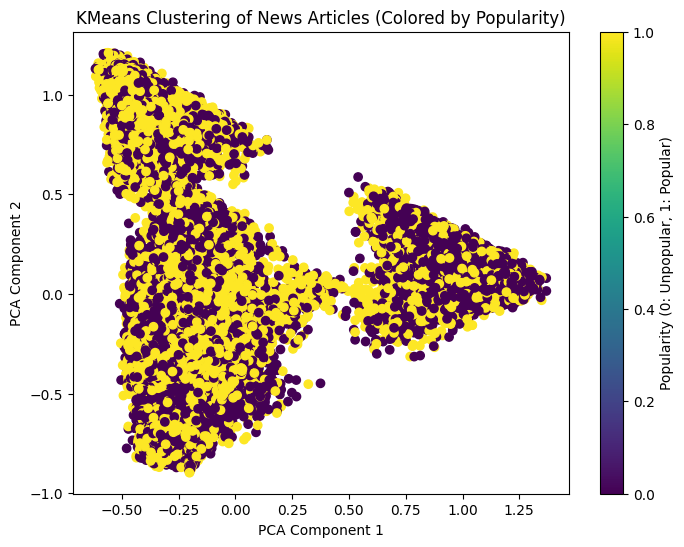

In [91]:
# Visualize the clusters and color them by popularity
plt.figure(figsize=(8, 6))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=news_pop['pop_label'], cmap='viridis')
plt.title('KMeans Clustering of News Articles (Colored by Popularity)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Popularity (0: Unpopular, 1: Popular)')
plt.show()


Cluster Centroids:
     n_tokens_title   n_tokens_content   n_unique_tokens   n_non_stop_words  \
0          0.411540           0.072593          0.000716           0.000925   
1          0.395087           0.044827          0.000854           0.000960   
2          0.396256           0.069347          0.000758           0.000958   
3          0.395371           0.067608          0.000776           0.000959   
4          0.426269           0.069250          0.000782           0.000959   
5          0.369163           0.074049          0.000754           0.000958   
6          0.363465           0.072492          0.000766           0.000960   
7          0.378028           0.036527          0.000929           0.000960   
8          0.388049           0.065815          0.000758           0.000959   
9          0.409206           0.070442          0.000733           0.000939   
10         0.439130           0.075879          0.000782           0.000960   
11         0.383951           0.0

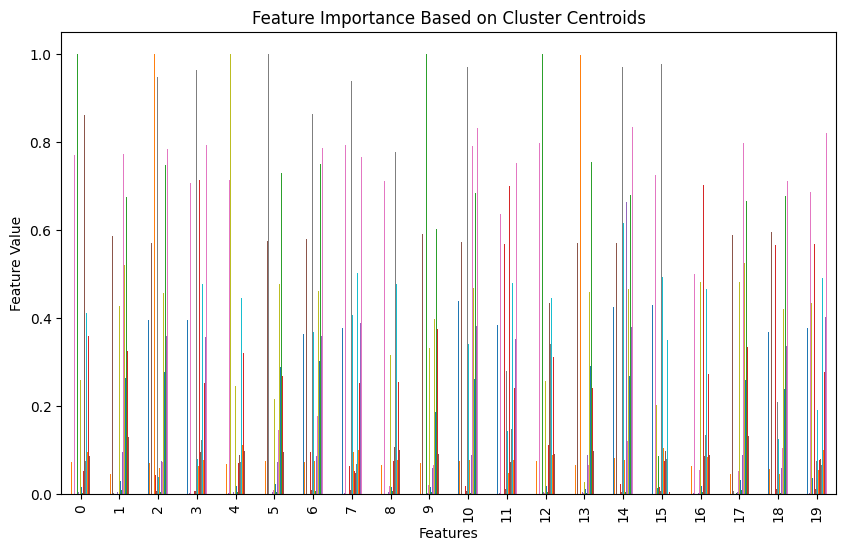

In [ ]:
# Get the centroids of the clusters
centroids = kmeans.cluster_centers_

# Create a DataFrame to display the centroids
centroid_df = pd.DataFrame(centroids, columns=features.columns)

print("Cluster Centroids:")
print(centroid_df)

# Visualize the centroids
centroid_df.plot(kind='bar', figsize=(10, 6),legend=False)
plt.title('Feature Importance Based on Cluster Centroids')
plt.ylabel('Feature Value')
plt.xlabel('Features')
plt.xticks(rotation=90)
plt.show()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


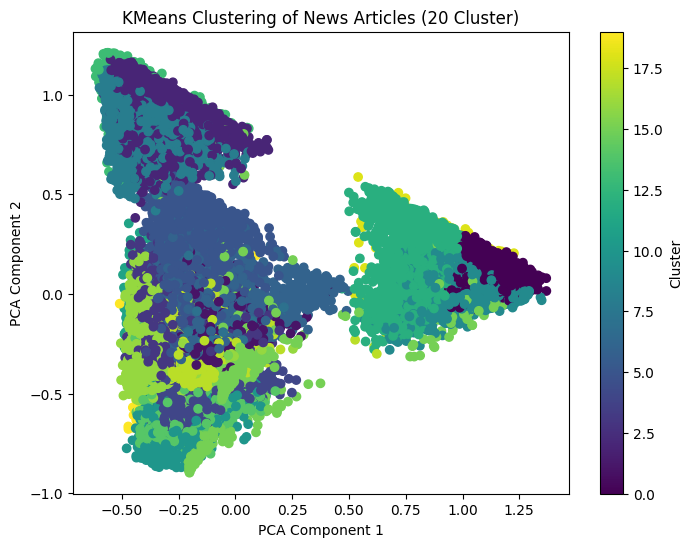

In [ ]:
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

# KMeans clustering
kmeans = KMeans(n_clusters=20, random_state=42)
news_pop['cluster'] = kmeans.fit_predict(features_scaled)

# Visualize the clusters in a 2D
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(features_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=news_pop['cluster'], cmap='viridis')
plt.title('KMeans Clustering of News Articles (20 Cluster)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

In [ ]:
# Compare clusters with popularity
cluster_popularity_comparison = news_pop.groupby('cluster')['pop_label'].mean()

print("Comparison of Clusters with Popularity:")
print(cluster_popularity_comparison)

Comparison of Clusters with Popularity:
cluster
0     0.294876
1     0.591739
2     0.546541
3     0.447029
4     0.348996
5     0.567121
6     0.718472
7     0.565354
8     0.639021
9     0.318524
10    0.392354
11    0.493703
12    0.435500
13    0.621861
14    0.367089
15    0.556225
16    0.519608
17    0.656428
18    0.438662
19    0.489152
Name: pop_label, dtype: float64


In [ ]:
# Calculate the counts of 'pop_label' in each cluster
cluster_popularity_counts = news_pop.groupby('cluster')['pop_label'].value_counts()

print("Cluster Purity (Distribution of Popularity within Each Cluster):")
print(cluster_popularity_counts)

Cluster Purity (Distribution of Popularity within Each Cluster):
cluster  pop_label
0        0            2078
         1             869
1        1            1232
         0             850
2        1            1920
         0            1593
3        0            1545
         1            1249
4        0            1427
         1             765
5        1            1166
         0             890
6        1            1618
         0             634
7        1             359
         0             276
8        1            2011
         0            1136
9        0            1902
         1             889
10       0            1510
         1             975
11       0             402
         1             392
12       0            1164
         1             898
13       1             421
         0             256
14       0            1100
         1             638
15       1             554
         0             442
16       1            1378
         0            127

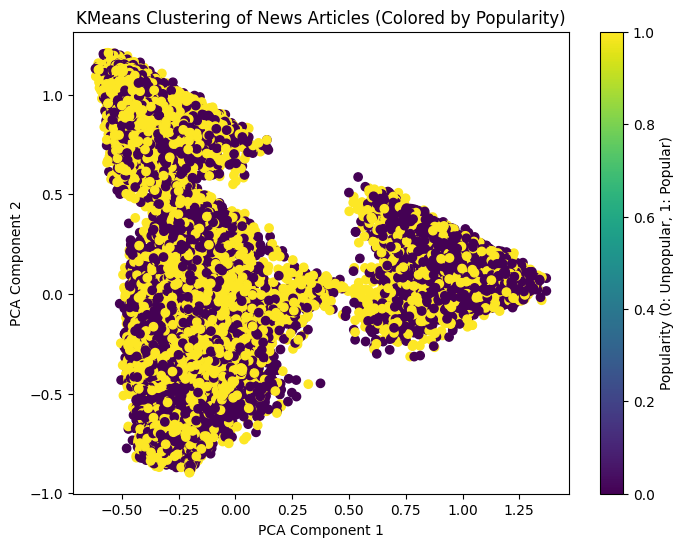

In [ ]:
# Clusters and color them by popularity
plt.figure(figsize=(8, 6))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=news_pop['pop_label'], cmap='viridis')
plt.title('KMeans Clustering of News Articles (Colored by Popularity)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Popularity (0: Unpopular, 1: Popular)')
plt.show()

Cluster Centroids:
     n_tokens_title   n_tokens_content   n_unique_tokens   n_non_stop_words  \
0          0.411540           0.072593          0.000716           0.000925   
1          0.395087           0.044827          0.000854           0.000960   
2          0.396256           0.069347          0.000758           0.000958   
3          0.395371           0.067608          0.000776           0.000959   
4          0.426269           0.069250          0.000782           0.000959   
5          0.369163           0.074049          0.000754           0.000958   
6          0.363465           0.072492          0.000766           0.000960   
7          0.378028           0.036527          0.000929           0.000960   
8          0.388049           0.065815          0.000758           0.000959   
9          0.409206           0.070442          0.000733           0.000939   
10         0.439130           0.075879          0.000782           0.000960   
11         0.383951           0.0

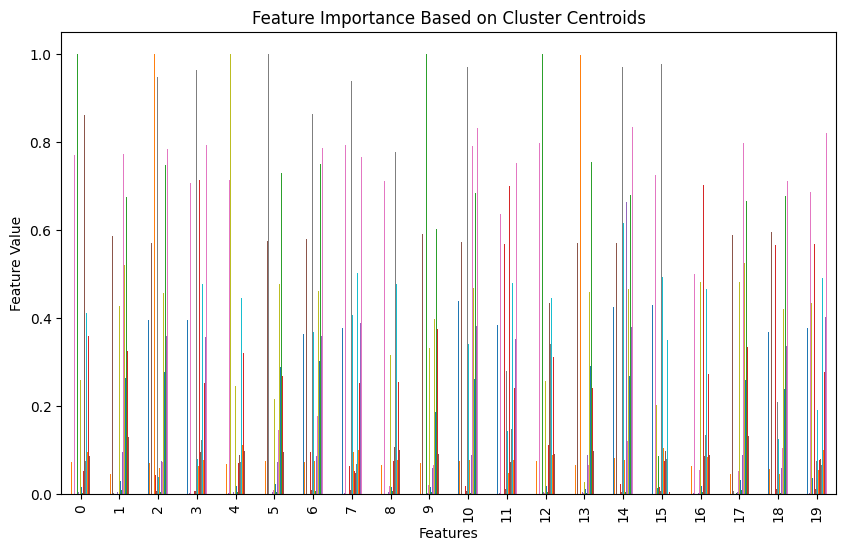

In [ ]:
# Centroids of the clusters
centroids = kmeans.cluster_centers_

centroid_df = pd.DataFrame(centroids, columns=features.columns)

print("Cluster Centroids:")
print(centroid_df)

# Visualize the centroids
centroid_df.plot(kind='bar', figsize=(10, 6), legend=False)
plt.title('Feature Importance Based on Cluster Centroids')
plt.ylabel('Feature Value')
plt.xlabel('Features')
plt.xticks(rotation=90)
plt.show()


Testing DBSCAN with eps=0.6


/var/folders/t0/t06xz7jx0v92cq5zx7ykzyt80000gn/T/ipykernel_28867/3889077156.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['Cluster'] = clusters_dbc


Number of clusters: 14
Number of noise points: 2546
Cluster sizes:
 6     7637
 1     7178
 9     6185
 3     6028
 7     4617
-1     2546
 8     1628
 10    1546
 12     624
 2      463
 0      394
 11     242
 4      229
 5      225
 13     102
Name: count, dtype: int64


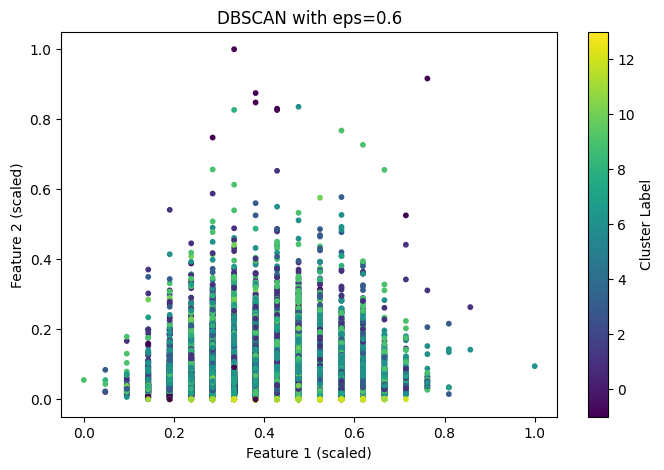


Testing DBSCAN with eps=0.62


/var/folders/t0/t06xz7jx0v92cq5zx7ykzyt80000gn/T/ipykernel_28867/3889077156.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['Cluster'] = clusters_dbc


Number of clusters: 13
Number of noise points: 2087
Cluster sizes:
 0     8075
 1     7213
 8     6223
 3     6079
 6     4672
-1     2087
 7     1669
 9     1651
 11     627
 2      477
 10     247
 4      246
 5      246
 12     132
Name: count, dtype: int64


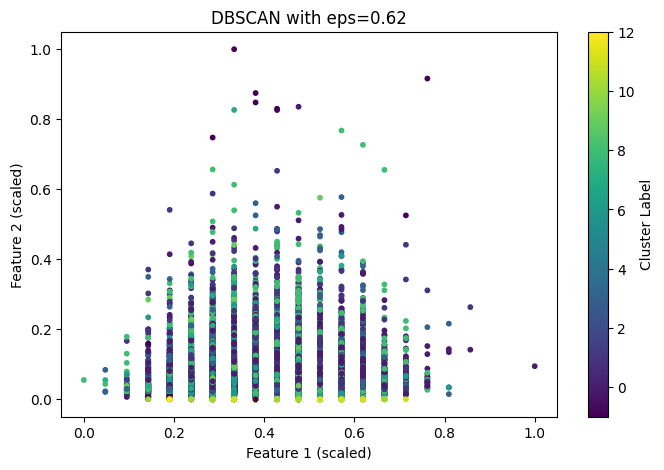


Testing DBSCAN with eps=0.64


/var/folders/t0/t06xz7jx0v92cq5zx7ykzyt80000gn/T/ipykernel_28867/3889077156.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['Cluster'] = clusters_dbc


Number of clusters: 12
Number of noise points: 1580
Cluster sizes:
 0     8110
 1     7240
 7     6258
 5     6120
 3     5304
 8     1756
 6     1704
-1     1580
 10     629
 4      283
 2      261
 9      250
 11     149
Name: count, dtype: int64


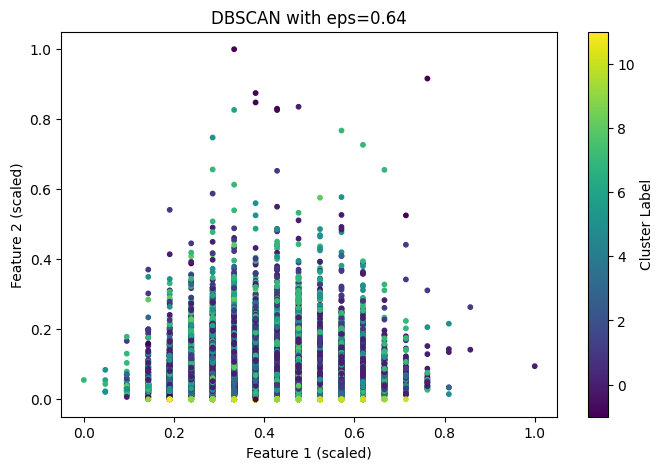


Testing DBSCAN with eps=0.66


/var/folders/t0/t06xz7jx0v92cq5zx7ykzyt80000gn/T/ipykernel_28867/3889077156.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['Cluster'] = clusters_dbc


Number of clusters: 11
Number of noise points: 1160
Cluster sizes:
 0     8122
 1     7261
 4     6713
 5     6176
 3     5352
 7     1825
 6     1721
-1     1160
 9      632
 2      276
 8      251
 10     155
Name: count, dtype: int64


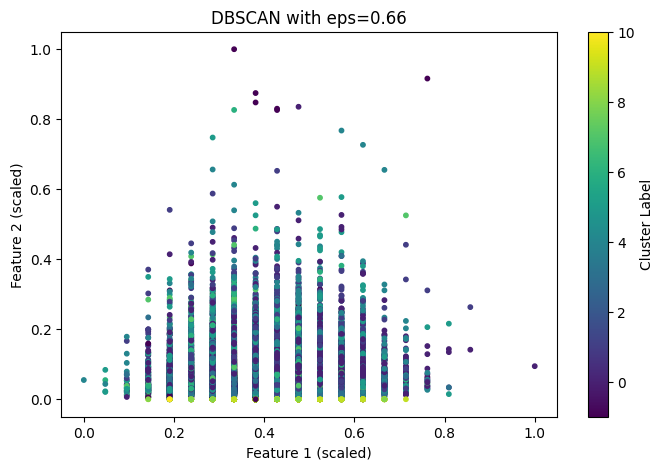


Testing DBSCAN with eps=0.68


/var/folders/t0/t06xz7jx0v92cq5zx7ykzyt80000gn/T/ipykernel_28867/3889077156.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['Cluster'] = clusters_dbc


Number of clusters: 10
Number of noise points: 921
Cluster sizes:
 0    8135
 1    7279
 4    6781
 5    6191
 3    5390
 2    2030
 6    1876
-1     921
 8     633
 7     251
 9     157
Name: count, dtype: int64


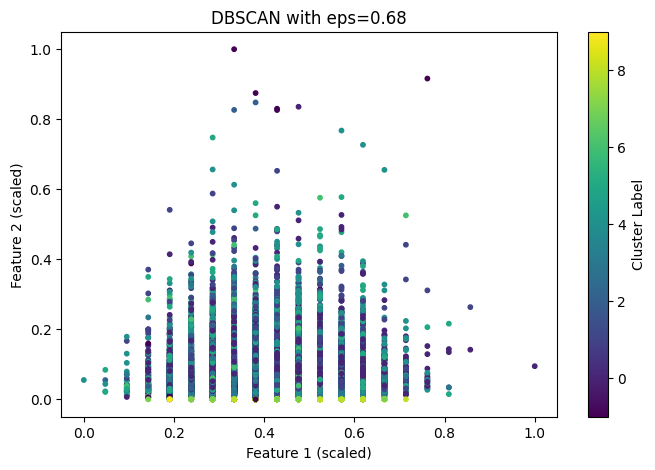

/var/folders/t0/t06xz7jx0v92cq5zx7ykzyt80000gn/T/ipykernel_28867/3889077156.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features.drop(columns=['Cluster'], inplace=True)


In [ ]:
x_dbscan_features_2 = features
scaler_dbc = MinMaxScaler()
x_dbc_scaled = scaler_dbc.fit_transform(x_dbscan_features_2)

db_eps_values = np.arange(0.6,0.7,0.02)

# Iterate over eps values and analyze the results
for eps in db_eps_values:
    print(f"\nTesting DBSCAN with eps={eps}")
    dbscan_cluster_dbc = DBSCAN(eps=eps, min_samples=100)  # Adjust min_samples if necessary
    clusters_dbc = dbscan_cluster_dbc.fit_predict(x_dbc_scaled)

    # Add the cluster labels to the data temporarily
    features['Cluster'] = clusters_dbc

    # Analyze the results
    n_clusters_dbc = len(set(clusters_dbc)) - (1 if -1 in clusters_dbc else 0)
    n_noise_dbc = list(clusters_dbc).count(-1)

    print(f"Number of clusters: {n_clusters_dbc}")
    print(f"Number of noise points: {n_noise_dbc}")

    # Optional: Calculate and display cluster sizes
    cluster_sizes_dbc = pd.Series(clusters_dbc).value_counts()
    print("Cluster sizes:")
    print(cluster_sizes_dbc)

    # Optional: Plot the results (2D projection)
    plt.figure(figsize=(8, 5))
    plt.title(f"DBSCAN with eps={eps}")
    plt.scatter(x_dbc_scaled[:, 0], x_dbc_scaled[:, 1], c=clusters_dbc, cmap='viridis', s=10)
    plt.colorbar(label='Cluster Label')
    plt.xlabel("Feature 1 (scaled)")
    plt.ylabel("Feature 2 (scaled)")
    plt.show()

# Remove the temporary 'Cluster' column from your dataset
features.drop(columns=['Cluster'], inplace=True)

### ARI and NMI

In [115]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

y_db = news_pop['pop_label']
ari = adjusted_rand_score(y_db, clusters_dbc)
nmi = normalized_mutual_info_score(y_db, clusters_dbc)

print(f"Adjusted Rand Index (ARI): {ari:.4f}")
print(f"Normalized Mutual Information (NMI): {nmi:.4f}")

Adjusted Rand Index (ARI): 0.0174
Normalized Mutual Information (NMI): 0.0218


### Comparison of clusters with popularity

In [116]:
news_pop_db = news_pop.assign(clusters_dbc = clusters_dbc)
news_pop_db.head()

timedelta   n_tokens_title   n_tokens_content   n_unique_tokens  \
0       731.0             12.0              219.0          0.663594   
1       731.0              9.0              255.0          0.604743   
2       731.0              9.0              211.0          0.575130   
3       731.0              9.0              531.0          0.503788   
4       731.0             13.0             1072.0          0.415646   

    n_non_stop_words   n_non_stop_unique_tokens   num_hrefs   num_self_hrefs  \
0                1.0                   0.815385         4.0              2.0   
1                1.0                   0.791946         3.0              1.0   
2                1.0                   0.663866         3.0              1.0   
3                1.0                   0.665635         9.0              0.0   
4                1.0                   0.540890        19.0             19.0   

    num_imgs   num_videos  ...   max_negative_polarity   title_subjectivity  \
0        1.0          0.0  ...               -0.200000             0.500000   
1        1.0          0.0  ...               -0.100000             0.000000   
2        1.0          0.0  ...               -0.133333             0.000000   
3        1.0          0.0  ...               -0.166667             0.000000   
4       20.0          0.0  ...               -0.050000             0.454545   

    title_sentiment_polarity   abs_title_subjectivity  \
0                  -0.187500                 0.000000   
1                   0.000000                 0.500000   
2                   0.000000                 0.500000   
3                   0.000000                 0.500000   
4                   0.136364                 0.045455   

    abs_title_sentiment_polarity   shares  Cluster  pop_label  cluster  \
0                       0.187500      593       -1          0       19   
1                       0.000000      711       -1          0       11   
2                       0.000000     1500       -1          1       11   
3                       0.000000     1200       -1          0       19   
4                       0.136364      505       -1          0       13   

   clusters_dbc  
0            -1  
1             5  
2            -1  
3             4  
4             1  

[5 rows x 64 columns]

In [117]:
cluster_popularity_comparison_db = news_pop_db.groupby('clusters_dbc')['pop_label'].mean()

print("Comparison of Clusters with Popularity")
print(cluster_popularity_comparison_db)

Comparison of Clusters with Popularity
clusters_dbc
-1    0.626493
 0    0.342225
 1    0.592664
 2    0.564532
 3    0.610390
 4    0.372364
 5    0.483767
 6    0.732942
 7    0.498008
 8    0.584518
 9    0.388535
Name: pop_label, dtype: float64


### Popularity counts

In [ ]:
# Calculate the counts of 'pop_label' in each cluster
cluster_popularity_counts_db = news_pop_db.groupby('clusters_dbc')['pop_label'].value_counts()

print("Cluster Purity (Distribution of Popularity within Each Cluster):")
print(cluster_popularity_counts_db)

Cluster Purity (Distribution of Popularity within Each Cluster):
clusters_dbc  pop_label
-1            1             577
              0             344
 0            0            5351
              1            2784
 1            1            4314
              0            2965
 2            1            1146
              0             884
 3            1            3290
              0            2100
 4            0            4256
              1            2525
 5            0            3196
              1            2995
 6            1            1375
              0             501
 7            0             126
              1             125
 8            1             370
              0             263
 9            0              96
              1              61
Name: count, dtype: int64
